# Project

In [1]:
import os
import pandas as pd
import networkx as nx
import json
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from fa2_modified import ForceAtlas2
import re
import numpy as np
from scipy.stats import f_oneway

## Building Network

In [2]:
# set wd
os.chdir('/Users/kristineandersen/Desktop/Sociale grafer/Project/yelp_dataset/')

Firstly, importing the relevant data

In [6]:

with open('yelp_academic_dataset_review.json', 'r') as f:
    user_counts = Counter(json.loads(line)['user_id'] for line in f)


The full dataset is too large to work with. This means we are taking a subset of the data. The subset we will be doing the analysis on is every user who have made excatly 20 reviews (r=20). We will however compare this subset with other subsets to verify that our analysis can be put in a generel context for the dataset and doesn't only describe on the subset.

In [7]:
number_of_reviews = 20
count_users_reviews = sum(count == number_of_reviews for count in user_counts.values())
print(f'Number of users that has reviewed {number_of_reviews} times: {count_users_reviews}')

Number of users that has reviewed 20 times: 3024


In [ ]:
# Making the subset
with open('yelp_academic_dataset_review.json', 'r') as f, open(f'reviews_{number_of_reviews}.json', 'w') as out_f:
    lines = [json.loads(line) for line in f if user_counts[json.loads(line)['user_id']] == number_of_reviews]
    lines.sort(key=lambda x: (x['business_id']))

    # Write the subset to the new file
    for line in lines:
        out_f.write(json.dumps(line) + "\n")
        print(line) 

In [8]:
df = pd.read_json(f'reviews_{number_of_reviews}.json', lines=True)
chunk = df.copy()
#chunk.to_csv(f'Files/yelp_academic_dataset_review_small.csv', index=False)

In [9]:
chunk.head()

review_id                 user_id             business_id  \
0  T5442QeVY13MWJuKbvtgnQ  6SoUQtbIltsun0IIGqWTqA  ---kPU91CF4Lq2-WlRu9Lw   
1  c0PMuZecG8uKZpzlYEs36Q  QM3cNh-u31Z5alYC3h1RnA  --FcbSxK1AoEtEAxOgBaCw   
2  S8-rmUixe0CANmCMblYl2A  qi6OJ4D1e_T_AUQGHtadvA  --MbOh2O1pATkXa7xbU6LA   
3  dAoF6rmPQY72tejRqEwDKA  qgLwRvE6JkK_KnbuT5AKmA  --O3ip9NpXTKD4oBS1pY2A   
4  fqWMiA-8VpG-eTuF1YzZGQ  4lng77gRdpRb24o91sSihA  --S43ruInmIsGrnnkmavRw   

   stars  useful  funny  cool  \
0      4       0      0     0   
1      1       1      1     0   
2      4       1      0     0   
3      4       7      2     3   
4      3       3      1     1   

                                                text                date  
0  Excellent food and service. Portions are a lit... 2021-11-28 16:40:02  
1  I used to come here quite frequently but never... 2018-05-13 13:12:18  
2  For what it is, they make a solid product.  Li... 2013-04-14 22:31:08  
3  There are only a few Kid Friendly places in Sa... 2017-02-11 18:55:08  
4  While I liked the layout and some of the selec... 2015-03-22 23:56:41

In [10]:
# number of reviews
print(len(chunk))

60480


In [11]:
# find distinct users and businesses
users = chunk['user_id'].unique()
businesses = chunk['business_id'].unique()

print(f'Number of users: {len(users)}')
print(f'Number of businesses: {len(businesses)}')

Number of users: 3024
Number of businesses: 31533


We can see here, that our subset we are working with consists of 60,480 reviews. This is spread out on 3,024 user and 31,533 businesses. Every review has a review_id, which helps us distingush between the reviews, as well as a user_id and business_id. The 'text' in every review is the text that the user have written about the business, and 'stars' are how many stars the user gave the business. 'useful', 'funny' and 'cool' is other users that have rated the review on those three parameters. 'date' is when the review was written.

We want to build the graph in such way, that every user is a node, and two nodes are connected if they have reviewed the same business. We will then work with the greatest component in the network.

In [13]:

business_groups = df.groupby('business_id')['user_id'].apply(list)

G = nx.Graph()

for users in business_groups:
    # Add edges between all pairs of users for the same business
    for user1, user2 in combinations(users, 2):
        if user1 != user2:  # Ensure no self-loops
            if G.has_edge(user1, user2):
                # add weight if edge already exists
                G[user1][user2]['weight'] += 1
            else:
                # edge with weight=1 if it doesn't exist
                G.add_edge(user1, user2, weight=1)

In [ ]:
# taking the greatest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

100%|██████████| 2000/2000 [00:34<00:00, 58.10it/s]


BarnesHut Approximation  took  16.53  seconds
Repulsion forces  took  15.25  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.99  seconds
AdjustSpeedAndApplyForces step  took  0.73  seconds


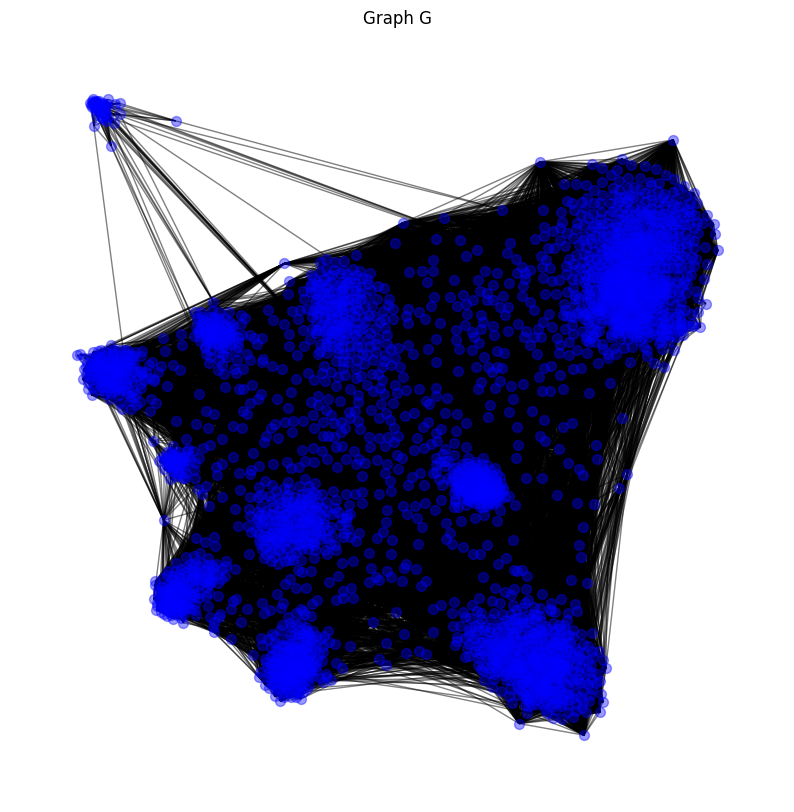

In [15]:
# plotting the graph
forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True,
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,
                        jitterTolerance=1.0,
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5)
plt.axis('off')
plt.title("Graph G")
plt.show()

The nodes are densely clustered in some hubs, indicating distinct communities or groups. The network structure shows a high level of interconnectivity within clusters but sparser connections between clusters. This suggests a modular or community structure in the dataset.

## Testing groups: Creating the dataframes for different r (number of reviews)

This part is for testing the subset (r=20) to the others. This is separate from the analysis of the network. Here .csv files for different r's is created, where each line was a node in the network, and contained user_id, all the review_id's that the user have made, the average stars the user have given in the reviews, the average sentiment score the user have given in the reviews, and the centrality. 

The calculation on the average stars and the average sentiment score can be seen in the section "Sentiment Analysis"

In [ ]:
# This is tho save the graph as a csv file. 
# This is actually run later, when all attributes is added to the nodes.
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
# save the dataframe to a csv file
os.chdir('/Users/kristineandersen/Desktop/Sociale grafer/Project/dataframes/')
df.to_csv(f'graph_{number_of_reviews}.csv')

#### comparing the subsets

In [16]:
# set wd
os.chdir('/Users/kristineandersen/Desktop/Sociale grafer/Project/dataframes/')

In [17]:
# import the csv files created
for year in range(18, 24):
    globals()[f'df_{year}'] = pd.read_csv(f'graph_{year}.csv')

A one-way ANOVA test is made to test whether the different subsets can be assumed to be the same for this project. The ANOVA test is made on with parameters, namely the average star raing for the users and the average sentiment score for the users. We are also comparing the modularity for the different subsets.

In [18]:
# test with a one way anova test that groups are the same for all r
# H0: groups are the same for all r

star_rating = []
for rev in range(18, 24):
    star_rating.append(globals()[f'df_{rev}']['star_mean'])
res_star = f_oneway(*star_rating)
# p-value is 0.2202251833859523, so we cannot reject the null hypothesis

sentiment_mean = []
for rev in range(18, 24):
    sentiment_mean.append(globals()[f'df_{rev}']['sentiment'])
res_sent = f_oneway(*sentiment_mean)
# p-value is 0.34369910255036007, so we cannot reject the null hypothesis


In [19]:
# Using the Python Louvain-algorithm implementation to find communities each network
partition_louvain = community_louvain.best_partition(G)
print(f'{len(set(partition_louvain.values()))} communities were found')

# Calculating the modularity of the partition
modularity = community_louvain.modularity(partition_louvain, G)
print(f"Modularity of the partition: {modularity}")

11 communities were found
Modularity of the partition: 0.6509075187617123


We see 11 communities were found. This aligns well as we could see 11 hubs on the graph plotted earlier.

In [ ]:
# The modularity was safed every time the script was run for different r's
# The output modularity for the different r's are:
modu = [0.6494, 0.6444, 0.6509, 0.6349, 0.6557, 0.6453]

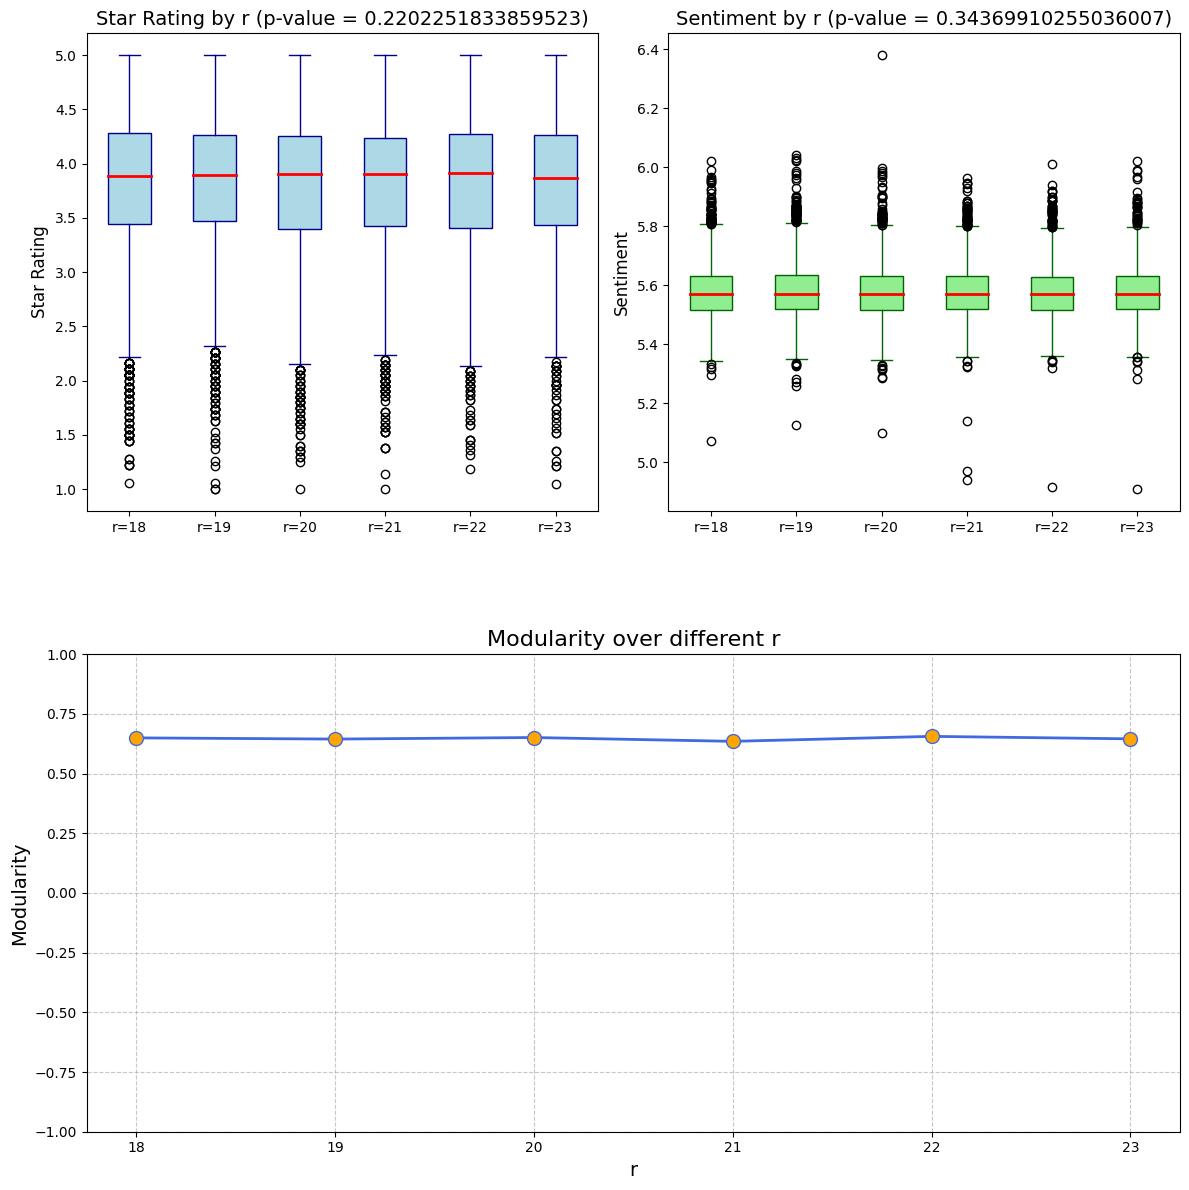

In [21]:
plt.figure(figsize=(12, 12))

# Star Rating Box Plot
plt.subplot(2, 2, 1)
plt.boxplot(star_rating, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='darkblue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='darkblue'),
            capprops=dict(color='darkblue'))
plt.xticks(range(1, 7), [f'r={year}' for year in range(18, 24)])
plt.ylabel('Star Rating', fontsize=12)
plt.title(f'Star Rating by r (p-value = {res_star.pvalue})', fontsize=14)

# Sentiment Mean Box Plot
plt.subplot(2, 2, 2)
plt.boxplot(sentiment_mean, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='darkgreen'),
            capprops=dict(color='darkgreen'))
plt.xticks(range(1, 7), [f'r={year}' for year in range(18, 24)])
plt.ylabel('Sentiment', fontsize=12)
plt.title(f'Sentiment by r (p-value = {res_sent.pvalue})', fontsize=14)

# Scatter Plot for Modularity
plt.subplot(2, 1, 2)
plt.plot(range(18, 24), modu, marker='o', linestyle='-', color='royalblue', markerfacecolor='orange', markersize=10, linewidth=2)
plt.xlabel('r', fontsize=14)
plt.ylabel('Modularity', fontsize=14)
plt.title('Modularity over different r', fontsize=16)
plt.ylim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust Layout and Enhance Readability
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Adjust spacing between plots

# Show the final plots
plt.show()


For both ANOVA tests, we see no evidence that the subsets are different from each other. This we can see by the hight p-values (above 0.05). The subsets are also plotted next to each other in the two boxplots above. Here we see that they look quite the same also, as confirmed with the p-value. For the modularity we don't see any outstanding values either. It looks like a pretty stable straight line. With all this, we have not found evidence that the subsets are different, this means, we are assuming that they are the same, and further analysis for this project, will be done on the subset where r=20.

## Preliminary Analysis on the network

In [22]:
# print number of nodes and edges
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

Number of nodes: 3024
Number of edges: 78349


In [23]:
# print degree stats
degrees = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees)}')
print(f'Lowest degree: {min(degrees)}')

Average degree: 51.8181216931217
Highest degree: 266
Lowest degree: 1


In [24]:
# make each review a user have made a node attribute
user_reviews = df.groupby('user_id')['review_id'].apply(list)
nx.set_node_attributes(G, user_reviews.to_dict(), 'reviews')

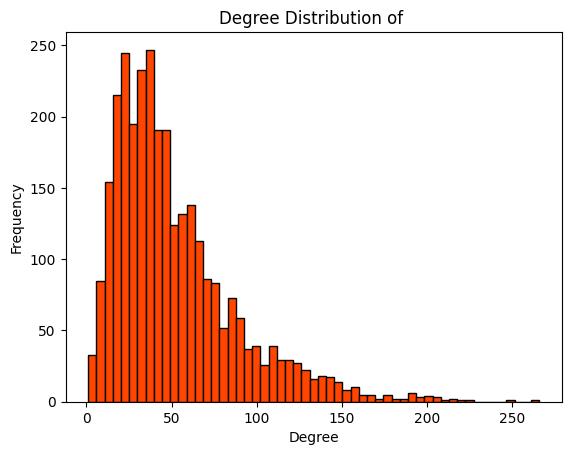

In [25]:
# plot the degree distribution in a histogram
plt.hist(degrees, bins=55, color='orangered', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of ')
plt.show()

The degree distribution plot reveals that most nodes have a low degree, with a few highly connected nodes. This right-skewed distribution suggests that the network is not uniformly connected but instead includes a small number of hubs—reviewers who have reviewed many businesses—while the majority have fewer connections.  
The degree distribution shows similarities to a scale-free network but with notable differences. In a true scale-free network, the degree distribution follows a power-law, where the tail remains heavy, and a few hubs dominate the connections. Here, while the distribution is right-skewed, the tail tapers off more sharply, suggesting that the network does not fully conform to the scale-free model.

# Sentiment analysis

As this data is reviews, and they are opinions of people, we think it will be interesting to look at the sentiment scores of the reviews, and to see if that is contributing to the community structure we see the graph has.

In [26]:
# some nessesary functions

# Tokenize text
def tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = re.findall(r'\b\w+\b', text)  # Simple word tokenizer
    return tokens

# function to calculate sentiment
def calculate_sentiment(tokens):
    tokens = [word.lower() for word in tokens]
    sentiments = [sentiment_dict.get(token, 0) for token in tokens if token in sentiment_dict]
    if sentiments:
        return sum(sentiments) / len(sentiments)
    return None

def basic_stats(list_of_values, print_stats=True):
    mean = np.mean(list_of_values)
    median = np.median(list_of_values)
    variance = np.var(list_of_values)
    percentile_25 = np.percentile(list_of_values, 25)
    percentile_75 = np.percentile(list_of_values, 75)
    max_value = np.max(list_of_values)
    min_value = np.min(list_of_values)
    if print_stats:
        print(f"Mean: {mean}")
        print(f"Median: {median}")
        print(f"Variance: {variance}")
        print(f"25th Percentile: {percentile_25}")
        print(f"75th Percentile: {percentile_75}")
        print(f"Max: {max_value}")
        print(f"Min: {min_value}")
    return mean, median, variance, percentile_25, percentile_75, max_value, min_value

In [27]:
# calculate the average stars given for each user
star_means = {}
for node in G.nodes:
    user = G.nodes[node]['reviews']
    stars = [chunk[chunk['review_id'] == review]['stars'].values[0] for review in user]
    star_means[node] = np.mean(stars)

nx.set_node_attributes(G, star_means, 'star_mean')

For the calculations of the sentiment scores, we look at the file "Data_Set_S1" found at http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752, using the happiness_rank

In [28]:
# loading the data "Data_Set_S1" and adding it to a dict
os.chdir("/Users/kristineandersen/Desktop/Sociale grafer")
file_path = 'Data_Set_S1.txt'
df = pd.read_csv(file_path, sep='\t')
sentiment_dict = dict(zip(df['word'].str.lower(), df['happiness_average']))

In [29]:
review_sentiments = dict()
for user in G.nodes():
    reviews = G.nodes[user]['reviews']
    for review in reviews:
        text = chunk[chunk['review_id'] == review]['text'].values[0]
        tokens = tokenize(text)
        sentiment = calculate_sentiment(tokens)
        if sentiment is not None:
            review_sentiments[review] = sentiment
        else:
            print(f'No sentiment for review {review}')

review_sentiments = pd.DataFrame(review_sentiments.items(), columns=['review_id', 'sentiment'])
review_sentiments.to_csv('review_sentiments.csv')

In [30]:
# calculate the sentiment for each user
sentiment_scores = []
for node in G.nodes:
    user = G.nodes[node]['reviews']
    temp_sentiment_scores = []
    for review in user:
        text = chunk[chunk['review_id'] == review]['text'].values[0]
        tokens = tokenize(text)
        sentiment_score = calculate_sentiment(tokens)
        if sentiment_score is not None:
            temp_sentiment_scores.append(sentiment_score)
            sentiment_scores.append(sentiment_score)
    if temp_sentiment_scores:
        G.nodes[node]['sentiment'] = sum(temp_sentiment_scores) / len(temp_sentiment_scores)
    else:
        G.nodes[node]['sentiment'] = None


Now, we will look at it in two different ways. One is the sentiment score per review, and the other is the average sentiment score per user, meaning here we concatenate all the text one user have written, and calculating the sentiment score of that.

In [31]:
review_mean, review_median, review_variance, review_percentile_25, review_percentile_75, review_max_value, review_min_value = basic_stats(sentiment_scores)

Mean: 5.578300881515234
Median: 5.5564705882352925
Variance: 0.041706457963498055
25th Percentile: 5.444221386591077
75th Percentile: 5.684927247307375
Max: 7.375
Min: 3.9899999999999998


In [32]:
user_mean, user_median, user_variance, user_percentile_25, user_percentile_75, user_max_value, user_min_value = basic_stats([G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node]['sentiment'] is not None])

Mean: 5.578300881515235
Median: 5.5702661894180086
Variance: 0.008572593532115359
25th Percentile: 5.516887974992507
75th Percentile: 5.632038508893346
Max: 6.379961014382443
Min: 5.100348612294782


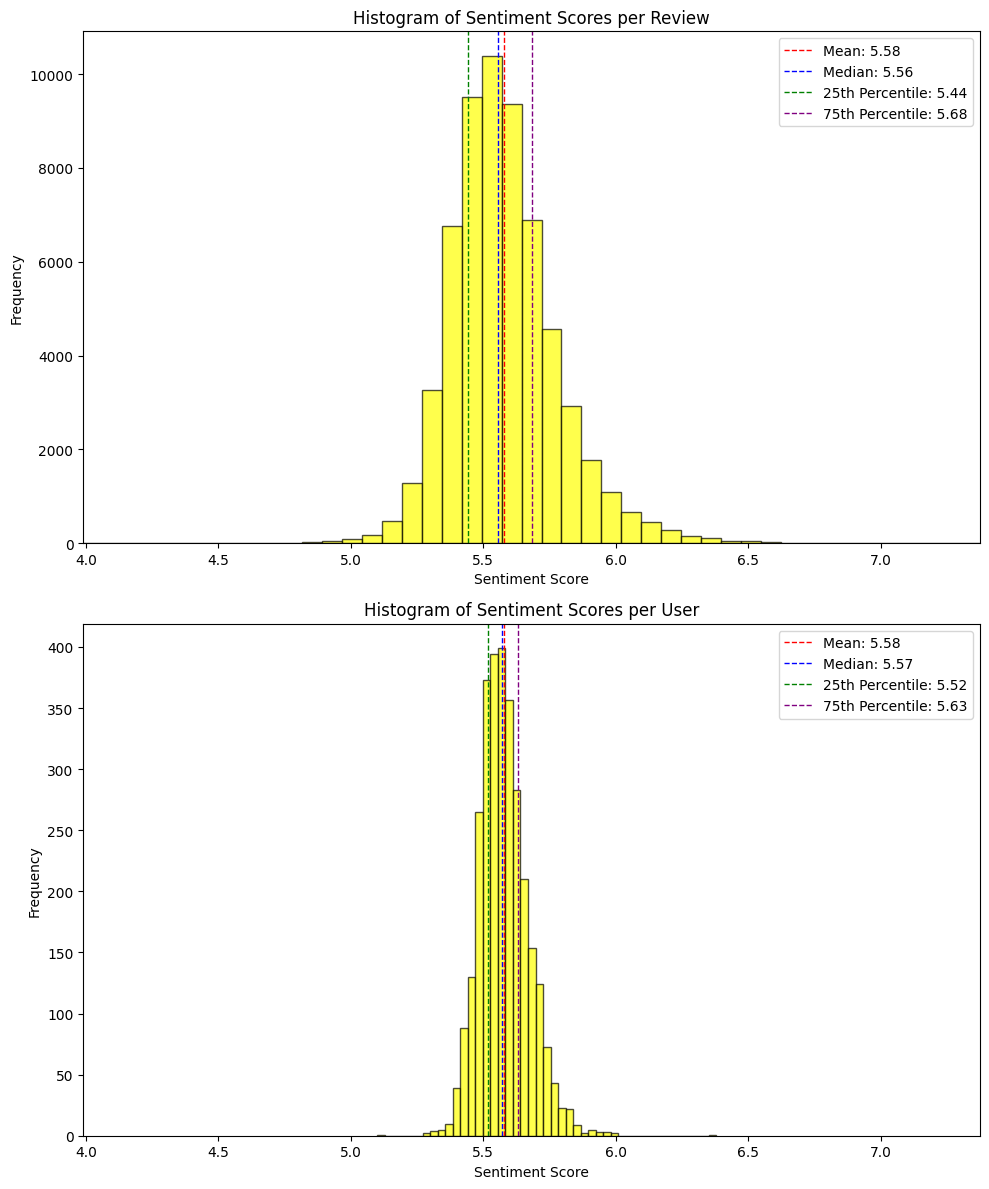

In [33]:
# Plot the histograms on top of each other
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Histogram of sentiment scores per review
axs[0].hist(sentiment_scores, bins=45, color='yellow', edgecolor='black', alpha=0.7)
axs[0].axvline(review_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {review_mean:.2f}')
axs[0].axvline(review_median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {review_median:.2f}')
axs[0].axvline(review_percentile_25, color='green', linestyle='dashed', linewidth=1, label=f'25th Percentile: {review_percentile_25:.2f}')
axs[0].axvline(review_percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {review_percentile_75:.2f}')
axs[0].legend()
axs[0].set_title('Histogram of Sentiment Scores per Review')
axs[0].set_xlabel('Sentiment Score')
axs[0].set_ylabel('Frequency')

# Histogram of sentiment scores per user
axs[1].hist([G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node]['sentiment'] is not None], bins=45, color='yellow', edgecolor='black', alpha=0.7)
axs[1].axvline(user_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {user_mean:.2f}')
axs[1].axvline(user_median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {user_median:.2f}')
axs[1].axvline(user_percentile_25, color='green', linestyle='dashed', linewidth=1, label=f'25th Percentile: {user_percentile_25:.2f}')
axs[1].axvline(user_percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {user_percentile_75:.2f}')
axs[1].legend()
axs[1].set_title('Histogram of Sentiment Scores per User')
axs[1].set_xlabel('Sentiment Score')
axs[1].set_ylabel('Frequency')

# Set the same x-axis limits for both histograms
axs[0].set_xlim([min(min(sentiment_scores), user_min_value), max(max(sentiment_scores), user_max_value)])
axs[1].set_xlim([min(min(sentiment_scores), user_min_value), max(max(sentiment_scores), user_max_value)])

plt.tight_layout()
plt.show()

The top plot shows the histogram of sentiment scores per review, with a wider range (min=3.98 and max=7.38), indicating more variability at the review level. The mean sentiment score is 5.58, and the spread is broader. The bottom plot displays the histogram of sentiment scores per user, which has a narrower range (min=5.10, max=6.38). This reflects aggregated scores per user, resulting in reduced variability. Although both have a mean sentiment score of 5.58, the bottom plot shows a tighter and more consistent distribution compared to the top plot. This means, when aggrigating the scores for each user, the text become more neutral, and we don't have a completly mad (or glad) person.

Now, we know the star rating is also a subejtice measure, and theoretically, when a person writes happier text, it would also mean the person would give more stars (as they are happy with the experience they had in the business). So, we would think a correlation would take place between the sentiment scores and the stars given. This we will look at below.

In [34]:
# Make a partition of the graph based on how many stars the users have given
star_partitions_user = {}
for node in G.nodes:
    user = G.nodes[node]['reviews']
    stars = [chunk[chunk['review_id'] == review]['stars'].values[0] for review in user]
    star_partitions_user[node] = np.mean(stars) 

# calculate  sentiment for each partition
partition_sentiments_user = {}
for partition in set(star_partitions_user.values()):
    partition_sentiments_user[partition] = [G.nodes[node]['sentiment'] for node in G.nodes if star_partitions_user[node] == partition and G.nodes[node]['sentiment'] is not None]

# calculate the mean sentiment for each partition
partition_means_user = {partition: np.mean(sentiments) for partition, sentiments in partition_sentiments_user.items()}


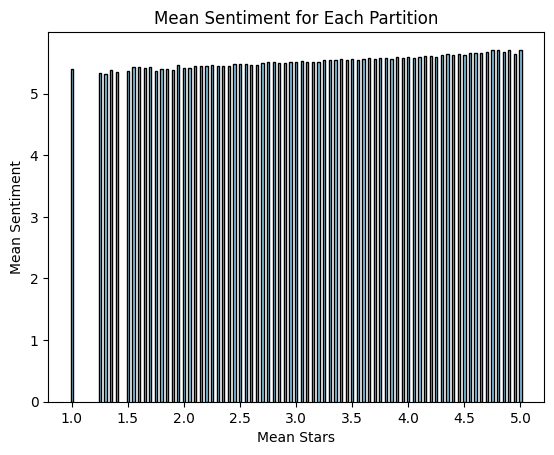

In [35]:
# plot the mean sentiment for each partition with thinner bars
plt.bar(partition_means_user.keys(), partition_means_user.values(), color='skyblue', edgecolor='black', width=0.02)
plt.xlabel('Mean Stars')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Partition')
plt.show()


In the above plot we see a slight increase in mean sentiment when mean stars increases. This suggests a correlation which would have to be investigated further, thus a correlation plot would make sense.

In [37]:
# correlation between sentiment and average stars
sentiments = [G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node]['sentiment'] is not None]
star_means = [G.nodes[node]['star_mean'] for node in G.nodes if G.nodes[node]['star_mean'] is not None]


correlation_sent_star = np.corrcoef(sentiments, star_means)[0, 1]
print(f"Correlation between sentiment and average stars: {correlation_sent_star:.2f}")


Correlation between sentiment and average stars: 0.62


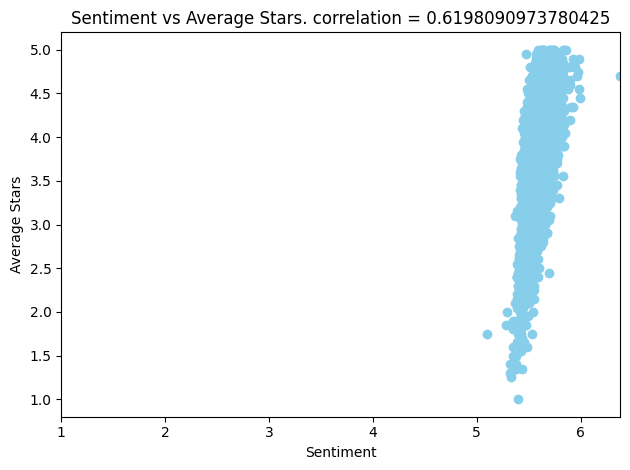

In [38]:
# Sentiment vs Average Stars
plt.scatter(sentiments, star_means, color='skyblue')
plt.title(f'Sentiment vs Average Stars. correlation = {correlation_sent_star}')
plt.xlabel('Sentiment')
plt.ylabel('Average Stars')

# Set the same x-axis limits for all subplots
x_min = min(min(sentiments), min(star_means))
x_max = max(max(sentiments), max(star_means))

plt.xlim([x_min, x_max])

plt.tight_layout()
plt.show()

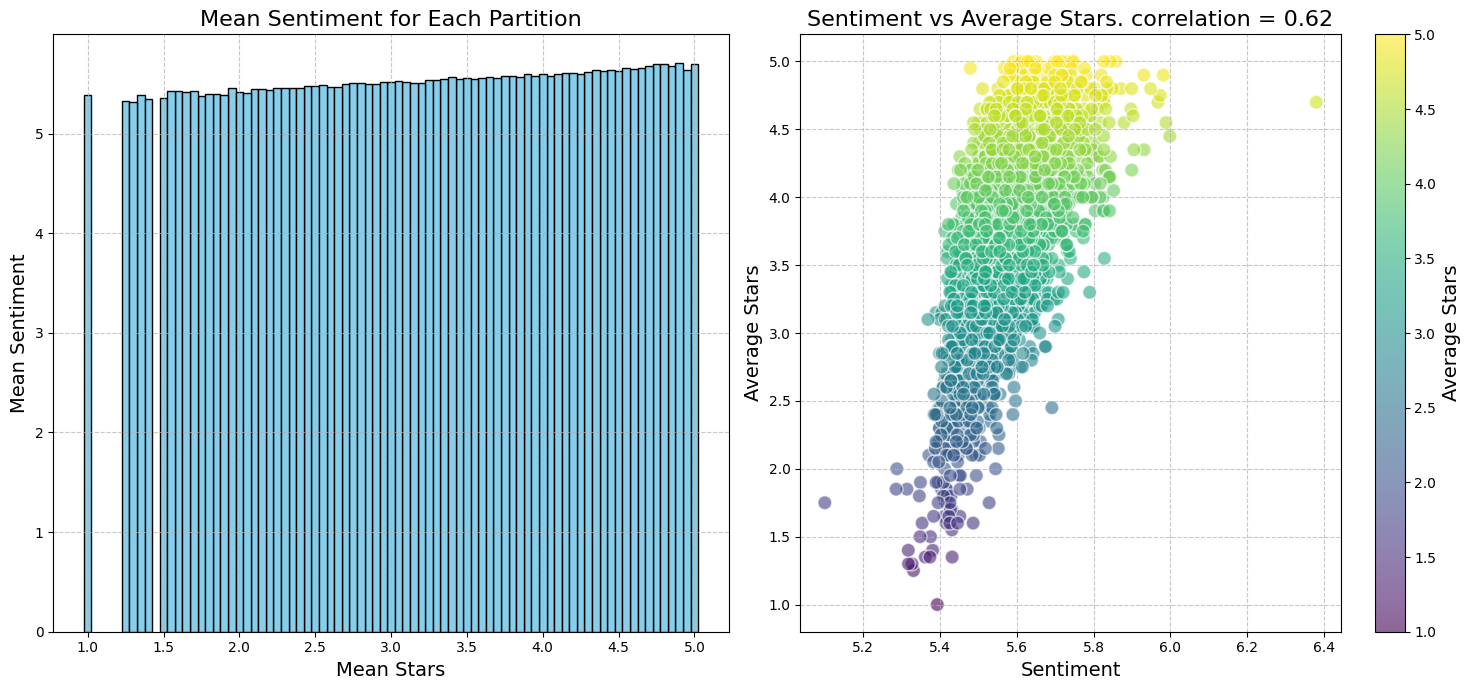

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Plot the mean sentiment for each partition with thinner bars
axes[0].bar(partition_means_user.keys(), partition_means_user.values(), color='skyblue', edgecolor='black', width=0.05)
axes[0].set_xlabel('Mean Stars', fontsize=14)
axes[0].set_ylabel('Mean Sentiment', fontsize=14)
axes[0].set_title('Mean Sentiment for Each Partition', fontsize=16)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Sentiment vs Average Stars
scatter = axes[1].scatter(sentiments, star_means, c=star_means, cmap='viridis', alpha=0.6, edgecolors='w', s=100)
axes[1].set_title(f'Sentiment vs Average Stars. correlation = {correlation_sent_star:.2f}', fontsize=16)
axes[1].set_xlabel('Sentiment', fontsize=14)
axes[1].set_ylabel('Average Stars', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Add color bar
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Average Stars', fontsize=14)

plt.tight_layout()
plt.show()

Here we see there is a moderate correlation between sentiment and star ratings, as the correlation cefficient is about 0.62 (and it is visible on the plot). It is however a bigger range in the sentiment score when the star rating are high, than when it's low. When the average star rating is under 2.5 (except one outstanding), the sentiment score is also under 5.6 (which is below the median and mean), while when the star rating is higher, there is a much wider soan in the sentiment score. 

It is also noticable here that the max sentiment score (which was 6.38) is actually quite far away from most of the point, meaning this could be an outlier, and then the range for the sentiment scores would be much lower, making it more neutral language.

Now, we have looked at these sentiment scores, but does this star rating and division of happy/mad people have an effect on the community structure of the graph? this we will have a look at below, by looking at the Louvian partition of the graph.

In [35]:
# calculate sentiment for each partition in partition_louvain
partition_sentiments_louvain = {}
for partition in set(partition_louvain.values()):
    partition_sentiments_louvain[partition] = [G.nodes[node]['sentiment'] for node in G.nodes if partition_louvain[node] == partition and G.nodes[node]['sentiment'] is not None]

# calculate the mean sentiment for each partition
partition_means_louvain = {partition: np.mean(sentiments) for partition, sentiments in partition_sentiments_louvain.items()}


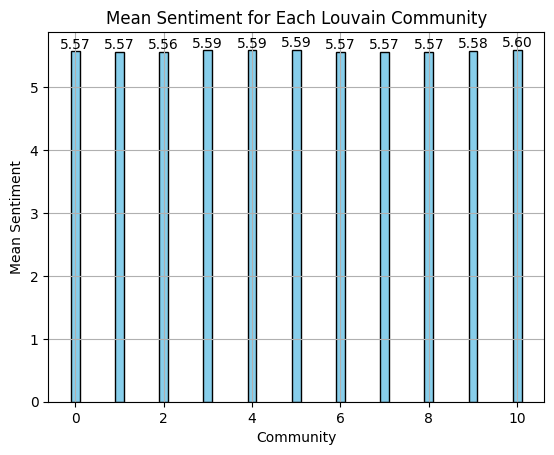

In [36]:
# plot the mean sentiment for each partition
plt.bar(partition_means_louvain.keys(), partition_means_louvain.values(), color='skyblue', edgecolor='black', width=0.2)
plt.xlabel('Community')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Louvain Community')
plt.grid(True)

# Add value labels on top of the bars
for community, sentiment in partition_means_louvain.items():
    plt.text(community, sentiment, f'{sentiment:.2f}', ha='center', va='bottom')

plt.show()

Well, it looks like the sentiment score is as close as it can get in the different communities.

In [37]:
# calculate average stars for each partition in partition_louvain
partition_star_louvain = {}
for partition in set(partition_louvain.values()):
    partition_star_louvain[partition] = [G.nodes[node]['star_mean'] for node in G.nodes if partition_louvain[node] == partition and G.nodes[node]['star_mean'] is not None]

# calculate the mean sentiment for each partition
partition_means_star_louvain = {partition: np.mean(star) for partition, star in partition_star_louvain.items()}

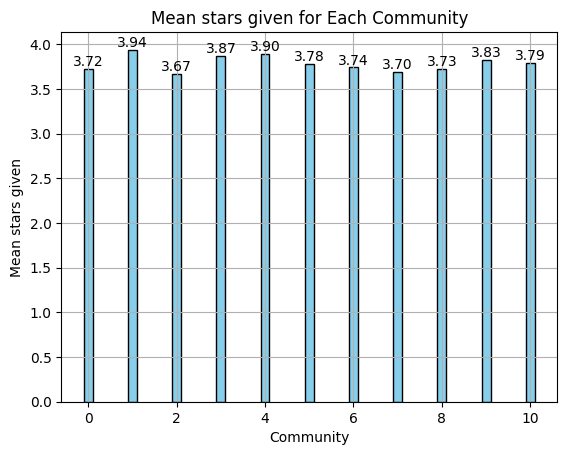

In [38]:
# plot the mean sentiment for each partition
plt.bar(partition_means_star_louvain.keys(), partition_means_star_louvain.values(), color='skyblue', edgecolor='black', width=0.2)
plt.xlabel('Community')
plt.ylabel('Mean stars given')
plt.title('Mean stars given for Each Community')
plt.grid(True)

# Add value labels on top of the bars
for community, star in partition_means_star_louvain.items():
    plt.text(community, star, f'{star:.2f}', ha='center', va='bottom')

plt.show()

And the star rating doesn't really change that much either for the different communities. We will however plot these, to get a visible understanding of this.

100%|██████████| 2000/2000 [00:39<00:00, 50.96it/s]


BarnesHut Approximation  took  17.12  seconds
Repulsion forces  took  19.22  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.99  seconds
AdjustSpeedAndApplyForces step  took  0.91  seconds


100%|██████████| 2000/2000 [00:36<00:00, 54.88it/s]


BarnesHut Approximation  took  14.85  seconds
Repulsion forces  took  18.75  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  0.98  seconds
AdjustSpeedAndApplyForces step  took  0.90  seconds


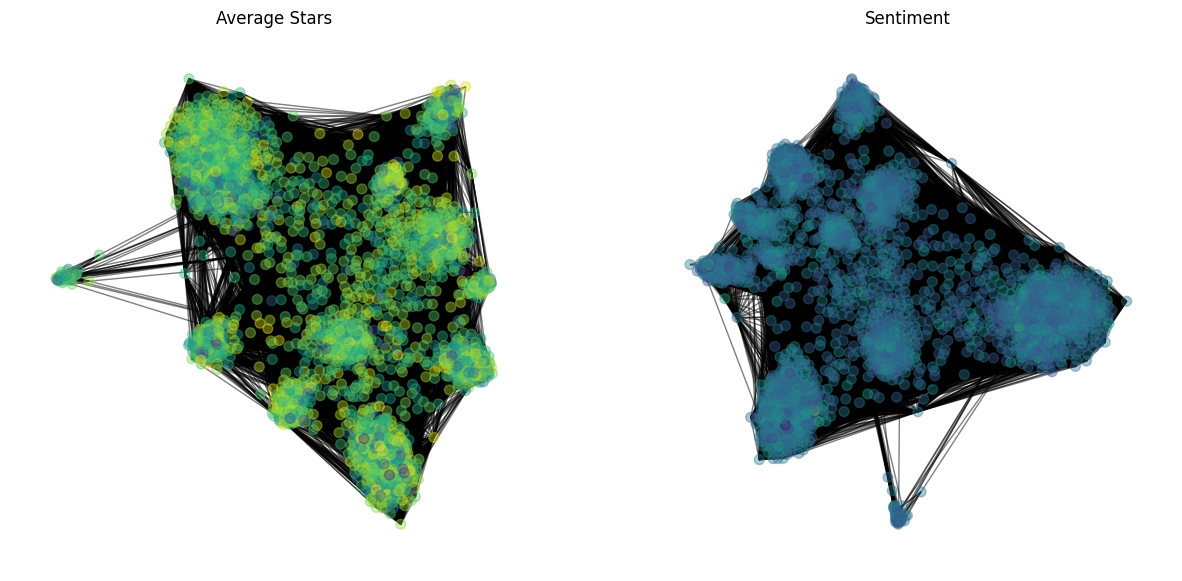

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns
forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True,
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,
                        jitterTolerance=1.0,
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
star_mean_dict = nx.get_node_attributes(G, 'star_mean')
star_colors = [star_mean_dict.get(n, 0) for n in G.nodes()]

plt.sca(axes[0])  # Set current axis to the first subplot
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=star_colors, alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5)
plt.axis('off')
plt.title("Average Stars")


forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True,
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,
                        jitterTolerance=1.0,
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
avg_sent_dict = nx.get_node_attributes(G, 'sentiment')
avg_sent_colors = [avg_sent_dict.get(n, 0) for n in G.nodes()]

# Draw the largest component on the second subplot
plt.sca(axes[1])  # Set current axis to the second subplot
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=avg_sent_colors, alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5)
plt.axis('off')
plt.title("Sentiment")

plt.show()

In the above to plot (left shows how the star ratings are in the different communities and right show how the sentiment scores are in the different communities) we don't really see any distingushment in the colors for the different communities, thus, we cannot say that the star rating or the sentiment score affect the structre.

In [47]:
# find the user who have a mean_star below 2
users_below_2 = [node for node in G.nodes if G.nodes[node]['star_mean'] < 2]
print(f'Number of users with a mean star below 2: {len(users_below_2)}')

Number of users with a mean star below 2: 47


100%|██████████| 2000/2000 [00:43<00:00, 45.60it/s]


BarnesHut Approximation  took  19.31  seconds
Repulsion forces  took  21.26  seconds
Gravitational forces  took  0.28  seconds
Attraction forces  took  1.15  seconds
AdjustSpeedAndApplyForces step  took  0.96  seconds


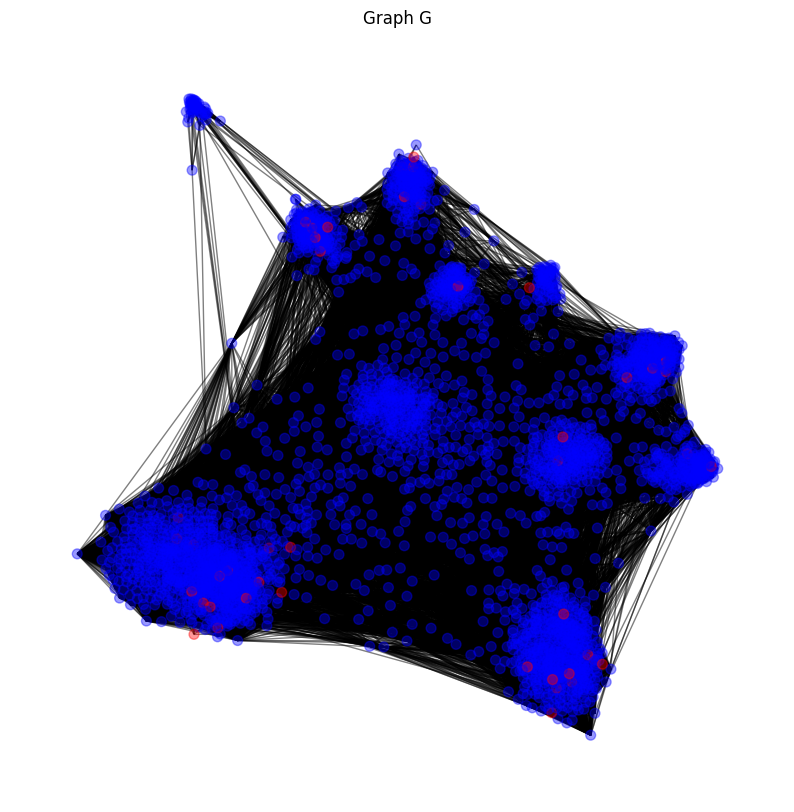

In [103]:
# color the users in users_below_2 differently in a plot of the network
forceatlas2 = ForceAtlas2(
                        outboundAttractionDistribution=True,
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,
                        jitterTolerance=1.0,
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
star_mean_dict = nx.get_node_attributes(G, 'star_mean')
star_colors = [star_mean_dict.get(n, 0) for n in G.nodes()]
node_colors = ['red' if node in users_below_2 else 'blue' for node in G.nodes()]

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5)
plt.axis('off')
plt.title("Graph G")
plt.show()

And also here is plotted the users who had an average star rating under 2. They are split out on the different communities, contributing to the conclusion above.

## Community Structure

In [49]:
import re
import os
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from scipy.sparse import lil_matrix
from collections import Counter
from itertools import combinations
import community.community_louvain as community_louvain

In [50]:
def plot_degree_distribution(degrees, title, ax, x_max, color):
    ax.hist(degrees, bins=30, color=color, edgecolor='black')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xlim(0, x_max)

def plot_degree_distributions(partition, G, community_counts, figsize=(18, 12)):
    # Group nodes by community
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    num_communities = len(communities)
    num_cols = 3
    num_rows = (num_communities + num_cols - 1) // num_cols  # Calculate the number of rows needed for 3 columns

    # Determine the maximum degree across all communities
    max_degree = max(G.degree(node) for node in G.nodes())

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    # Normalize community sizes for color mapping
    norm = mcolors.Normalize(vmin=min(community_counts.values()), vmax=max(community_counts.values()))
    cmap = plt.get_cmap('Oranges')

    for ax, (community_id, nodes) in zip(axes, communities.items()):
        degrees = [G.degree(node) for node in nodes]
        color = cmap(norm(community_counts[community_id]))
        plot_degree_distribution(degrees, f'Degree Distribution (Community {community_id})', ax, max_degree, color)

    # Hide any unused subplots
    for i in range(len(communities), len(axes)):
        fig.delaxes(axes[i])

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Number of Users in Community')

    fig.subplots_adjust(right=0.85)  # Adjust the right side to make space for the colorbar

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the tight layout to consider the colorbar
    plt.show()


def plot_edge_weight_distribution(weight_counts, title, ax, log_scale=False):
    ax.bar(weight_counts.keys(), weight_counts.values(), color='darkorange', edgecolor='black')
    ax.set_xlabel('Edge Weight')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    if log_scale:
        ax.set_yscale('log')

def plot_edge_weight_distributions(partition, G, plot_entire_graph=False, figsize=(18, 12)):
    if plot_entire_graph:
        fig, ax = plt.subplots(figsize=(9, 6))
        edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
        unique_weights = sorted(set(edge_weights))
        weight_counts = {weight: edge_weights.count(weight) for weight in unique_weights}
        
        # Determine if log scale is needed
        max_count = max(weight_counts.values())
        log_scale = max_count > 10 * sum(weight_counts.values()) / len(weight_counts)
        
        plot_edge_weight_distribution(weight_counts, 'Edge Weights (shared business reviews)', ax, log_scale)
        plt.tight_layout()
        plt.show()
        return

    # Group nodes by community
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    num_communities = len(communities)
    num_cols = 3
    num_rows = (num_communities + num_cols - 1) // num_cols  # Calculate the number of rows needed for 3 columns

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for ax, (community_id, nodes) in zip(axes, communities.items()):
        subgraph = G.subgraph(nodes)
        edge_weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
        unique_weights = sorted(set(edge_weights))
        weight_counts = {weight: edge_weights.count(weight) for weight in unique_weights}
        
        # Determine if log scale is needed
        max_count = max(weight_counts.values())
        log_scale = max_count > 10 * sum(weight_counts.values()) / len(weight_counts)
        
        plot_edge_weight_distribution(weight_counts, f'Edge Weights (Community {community_id})', ax, log_scale)

    # Hide any unused subplots
    for i in range(len(communities), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

def plot_community_metrics(df, metrics, figsize=(14, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration
    norm = mcolors.Normalize(vmin=df["Total Reviewers"].min(), vmax=df["Total Reviewers"].max())
    cmap = plt.get_cmap('Oranges')

    for ax, metric in zip(axes, metrics):
        colors = [cmap(norm(val)) for val in df["Total Reviewers"]]
        ax.bar(df["Community"], df[metric], color=colors, edgecolor='black')
        ax.set_xlabel("Community ID")
        ax.set_ylabel(metric.replace('_', ' '))
        ax.set_title(f"{metric.replace('_', ' ')} for Each Community")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Total Reviewers')

    plt.show()


In [ ]:
# load graph
G = nx.read_gml('graphs/init_graph.gml')

Unique edge weights =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 19]


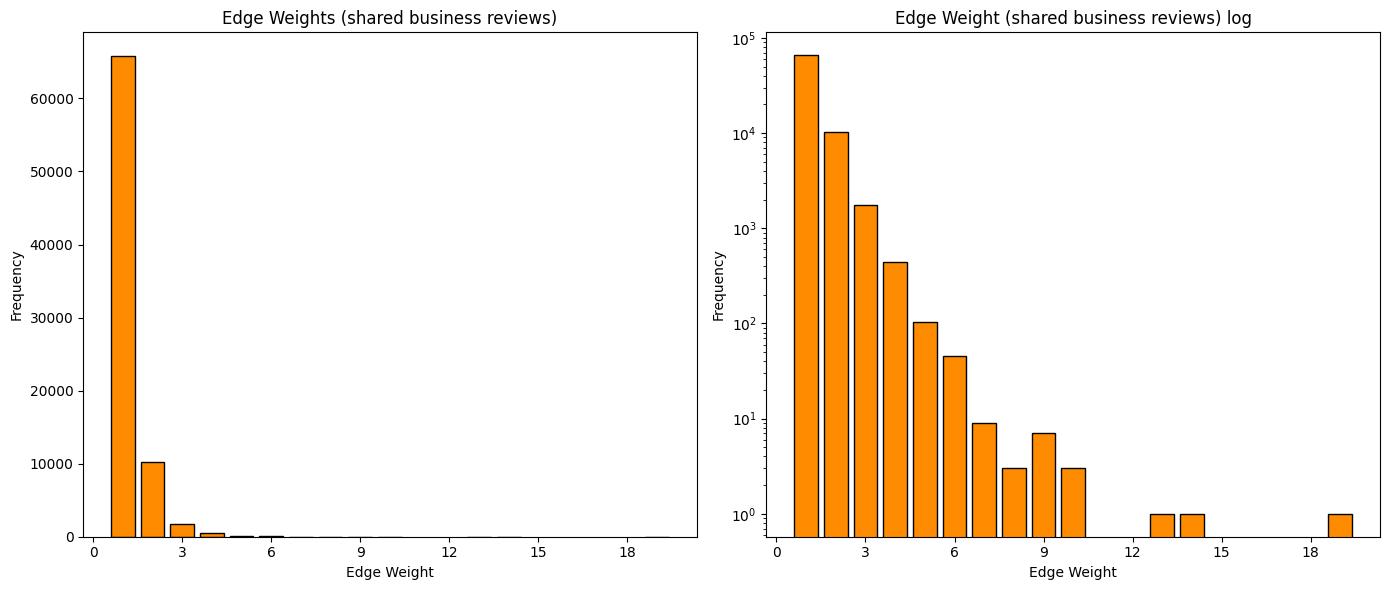

In [51]:
# Extract edge weights
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
unique_weights = sorted(set(edge_weights))
print("Unique edge weights = ", unique_weights)

# Calculate the frequency of each unique edge weight
weight_counts = {weight: edge_weights.count(weight) for weight in unique_weights}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the edge weight distribution as a bar plot (linear scale)
ax1.bar(weight_counts.keys(), weight_counts.values(), color='darkorange', edgecolor='black')
ax1.set_xlabel('Edge Weight')
ax1.set_ylabel('Frequency')
ax1.set_title('Edge Weights (shared business reviews)')
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the edge weight distribution as a bar plot (log scale)
ax2.bar(weight_counts.keys(), weight_counts.values(), color='darkorange', edgecolor='black')
ax2.set_xlabel('Edge Weight')
ax2.set_ylabel('Frequency')
ax2.set_title('Edge Weight (shared business reviews) log')
ax2.set_yscale('log')  # Use logarithmic scale for y-axis
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout()
plt.show()

By far the most reviewers only share a single reviewed business. Very reviewers have more than 10 businesses in common 

In [52]:
# Using the Python Louvain-algorithm implementation to find communities each network
partition = community_louvain.best_partition(G)
print(f'{len(set(partition.values()))} communities were found')

11 communities were found


To further analyze the relationships of reviewers and businesses, partitioning is used to explore the structure of the graph. 

The Louvain algorithm is particularly well-suited for this project due to its effectiveness in detecting communities within large networks. By optimizing modularity, it identifies groups of nodes that are densely connected internally while sparsely connected to other groups. This makes it well-aligned with the structure of the reviewer network, where natural clusters of users with overlapping business reviews are expected to emerge.

Compared to other partitioning methods, the Louvain algorithm offers a balance between computational efficiency and accuracy. Its hierarchical, iterative approach enables it to scale effectively to large graphs while providing meaningful community structures. Unlike spectral clustering, which can be computationally expensive for large networks, or simpler methods like edge-betweenness clustering, which often struggle with high complexity, Louvain is computationally efficient and can handle networks of significant size. Louvain offers flexibility in producing both coarse-grained and fine-grained partitions allowing for deeper exploration of the network's community dynamics.

In [53]:
# Calculating the modularity of the partition
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partition: {modularity}")

Modularity of the partition: 0.6506212432587383


The modularity score for the Louvain algorithm is notably high, indicating strong community structures within the graph. This suggests that the network is well-partitioned, with dense connections within communities and sparse connections between them. Such a result aligns with the dataset's nature, where reviewers sharing similar business preferences are expected to form distinct clusters.  
The high modularity supports the validity of the graph structure and provides a solid foundation for potential meaningful insights explored below.

In [54]:
community_counts = {}
for node in partition:
    community = partition[node]
    community_counts[community] = community_counts.get(community, 0) + 1

most_common_communities = sorted(community_counts, key=community_counts.get, reverse=True)

# number of users in each community
print("Number of users in each community:")
for i in most_common_communities:
    print(f'In community {i}, there were {community_counts[i]} users')

Number of users in each community:
In community 0, there were 867 users
In community 5, there were 504 users
In community 1, there were 341 users
In community 10, there were 260 users
In community 9, there were 255 users
In community 3, there were 193 users
In community 6, there were 185 users
In community 2, there were 179 users
In community 4, there were 125 users
In community 8, there were 67 users
In community 7, there were 48 users


The output highlights a clear imbalance in the size of the detected communities. Community 8 is the largest, with 867 users, while Community 7 is the smallest, with only 48 users. This might suggest that larger communities, such as Communities 8, 5, and 1, likely represent groups of users connected by widely reviewed or popular businesses, potentially reflecting general trends or more active regions. In contrast, smaller communities, like Communities 7, 0, and 4, may indicate niche reviewing behaviors or preferences for less commonly reviewed businesses. This distribution provides a solid starting point for deeper analysis into the characteristics, geographic patterns, or sentiment trends within each community.

/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_17567/3207548700.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the tight layout to consider the colorbar


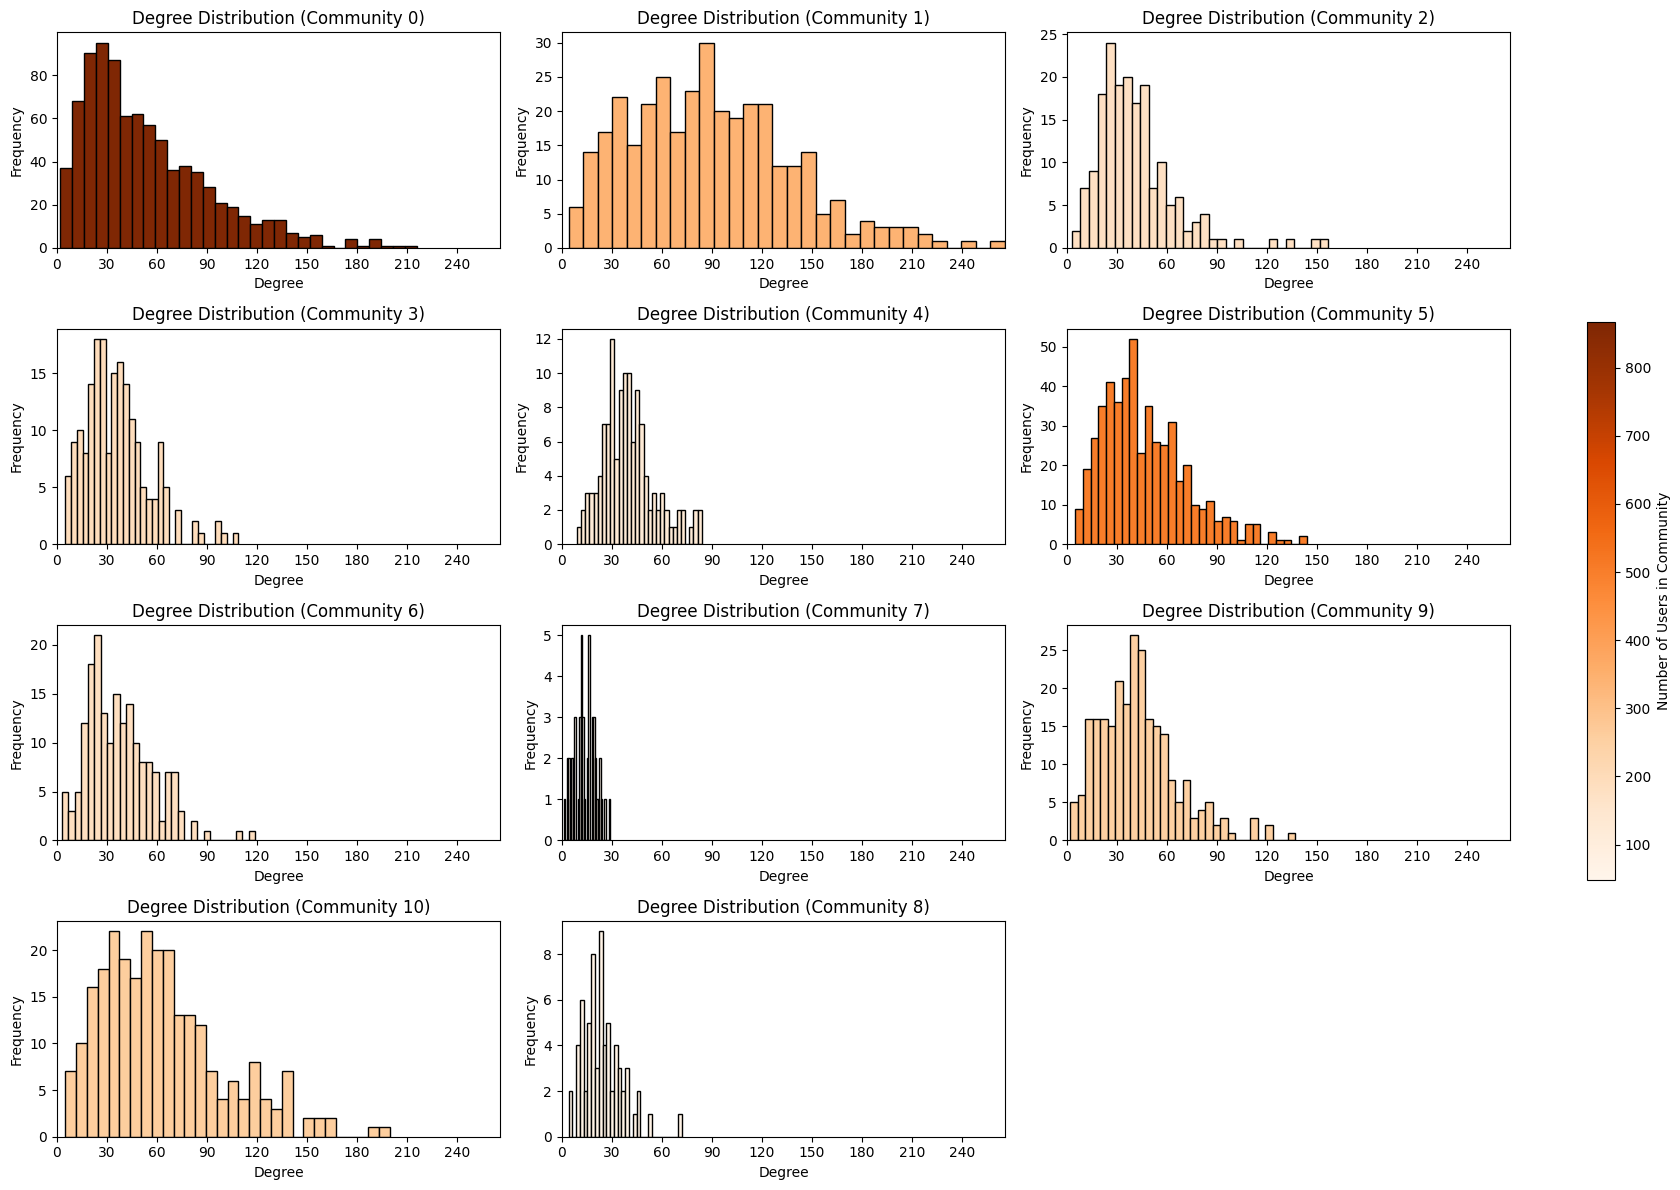

In [55]:
# community degree distributions
plot_degree_distributions(partition, G, community_counts)


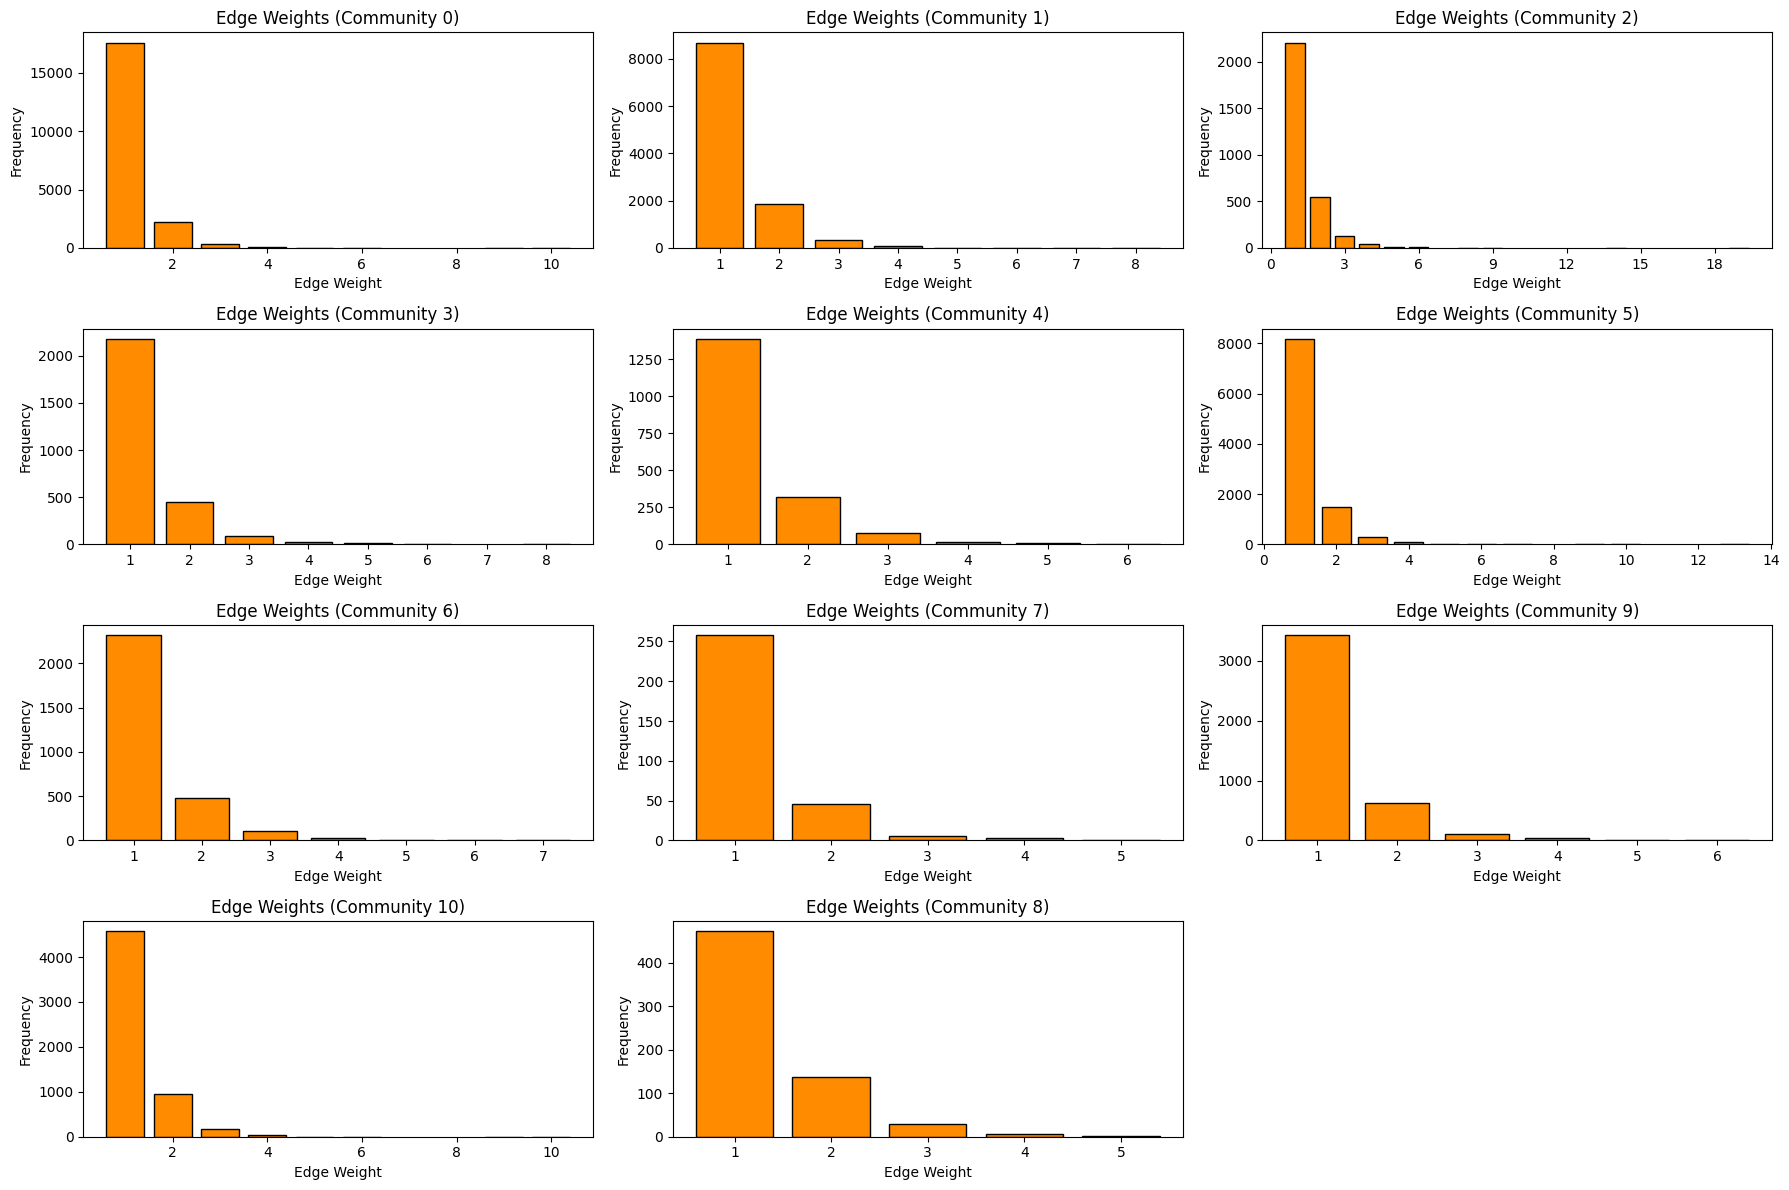

In [56]:
# Community edge weights
plot_edge_weight_distributions(partition, G)

To visualize the community structure in the full graph, network graph is created where nodes are colored according to their community, and edge thickness reflects the weights (number of shared businesses reviewed). This approach highlights the partitioning while emphasizing the strength of relationships between nodes. By adjusting the visualization to incorporate node size and edge width, we can effectively capture the dynamics of the graph in an interpretable and visually appealing way.

100%|██████████| 2000/2000 [00:01<00:00, 1833.74it/s]


BarnesHut Approximation  took  0.29  seconds
Repulsion forces  took  0.63  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


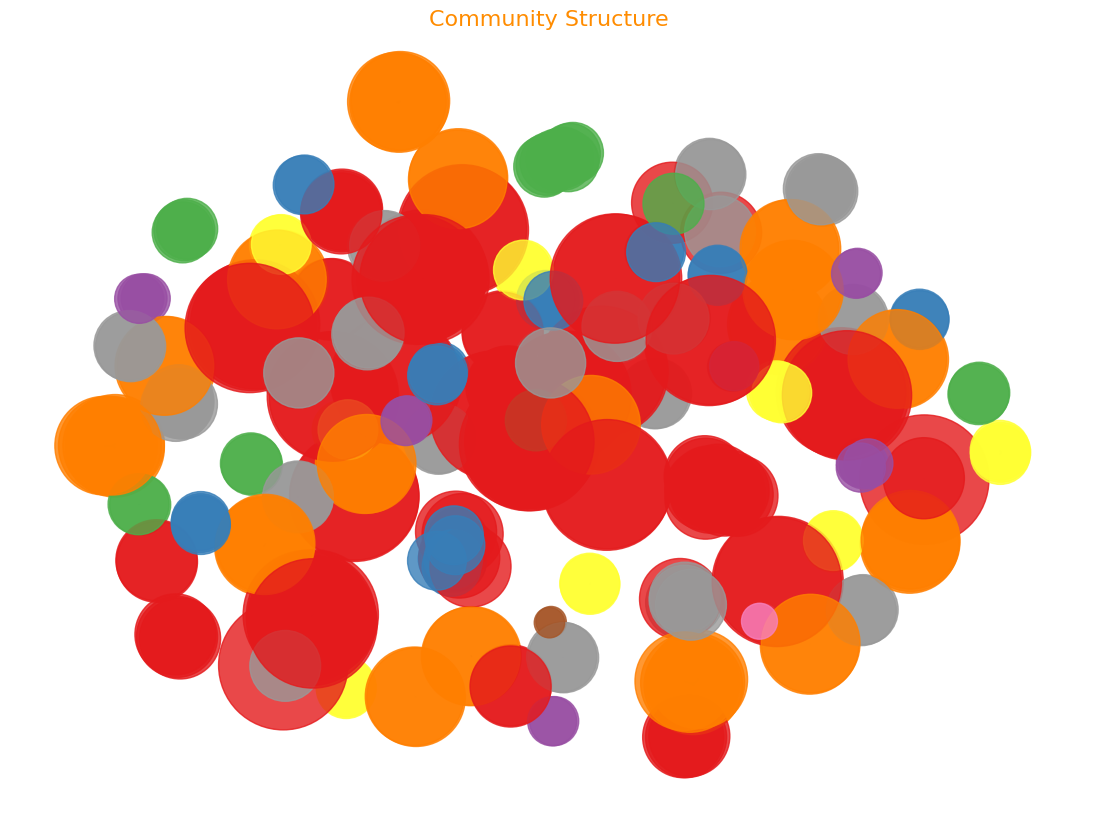

Edge thickness is proportional to the weight of the edges, representing shared businesses reviewed.
Node size is proportional to the size of the community, and node color represents the community membership.


In [58]:
# Visualize community structure

community_sizes = {comm: list(partition.values()).count(comm) for comm in set(partition.values())}
node_sizes = [community_sizes[partition[node]] * 10 for node in G.nodes]  # Adjust multiplier for visibility
threshold = 5  # Adjust threshold
filtered_edges = [(u, v) for u, v, w in G.edges(data='weight') if w >= threshold]
filtered_graph = G.edge_subgraph(filtered_edges).copy()

node_list = list(filtered_graph.nodes)
node_index = {node: idx for idx, node in enumerate(node_list)}
adj_matrix = lil_matrix((len(node_list), len(node_list)), dtype='f')

for u, v, data in filtered_graph.edges(data=True):
    adj_matrix[node_index[u], node_index[v]] = data['weight']
    adj_matrix[node_index[v], node_index[u]] = data['weight']  # Ensure symmetry for undirected graph

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,                     # Ensure it's disabled
    adjustSizes=False,                    # Ensure it's disabled
    edgeWeightInfluence=1.0,
    jitterTolerance=0.1,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    gravity=1.0,
    verbose=True
)
positions_array = forceatlas2.forceatlas2(adj_matrix, iterations=2000)
positions = {node: positions_array[idx] for node, idx in node_index.items()}
plt.figure(figsize=(14, 10))
edges, weights = zip(*nx.get_edge_attributes(filtered_graph, 'weight').items())
nx.draw_networkx_edges(
    filtered_graph, positions, edgelist=edges, alpha=0.5,
    width=[w * 0.1 for w in weights],  # Adjust multiplier for edge thickness
    edge_color=weights, edge_cmap=plt.cm.Blues  # Color edges by weight
)
nx.draw_networkx_nodes(
    filtered_graph, positions,
    node_color=[partition[node] for node in filtered_graph.nodes],
    cmap=plt.cm.Set1, node_size=[community_sizes[partition[node]] * 10 for node in filtered_graph.nodes], alpha=0.8
)
plt.title('Community Structure ', fontsize=16, color='darkorange')
plt.axis('off')
plt.show()

print("Edge thickness is proportional to the weight of the edges, representing shared businesses reviewed.")
print("Node size is proportional to the size of the community, and node color represents the community membership.")


### Community specific analysis: Aggregate metrics  
To better understand the network's structure and community dynamics, we will calculate key aggregate metrics for each community. These include the average degree, clustering coefficient, and edge density. These metrics might aid the understanding of the structural characteristics of each community and how they contribute to the overall network.

Focusing on individual communities helps us understand their internal dynamics more effectively, the following metrics are explored for each.

The average degree of a community gives insight into how well-connected the nodes within it are. It is calculated by averaging the degree (number of connections) of each node in the community. A higher average degree indicates a more interconnected and cohesive community.

The average clustering coefficient measures how likely the nodes in a community are to form tightly-knit groups, or cliques. It is calculated by averaging the clustering coefficient of each node, which assesses how many of a node’s neighbors are also connected to each other. Higher values suggest a more cohesive and tightly connected group.

Average betweenness centrality identifies nodes that act as bridges between different parts of the network. Nodes with high betweenness centrality are crucial for controlling the flow of information or resources. This metric is computed by assessing how often a node lies on the shortest path between other pairs of nodes, with higher values indicating more central nodes.

Average closeness centrality measures how efficiently a node can reach all other nodes in the network. It is calculated by averaging the shortest path lengths from each node to every other node in the community. Higher closeness centrality indicates nodes that can quickly access other nodes, making them important for spreading information or influence within the community.

These metrics help uncover the structural characteristics of communities, revealing how they interact with each other and their role within the broader network.

In [144]:
# TAKES A LONG TIME TO RUN

# Group nodes by their community IDs
community_dict = {}
for node, community in partition.items():
    if community not in community_dict:
        community_dict[community] = []
    community_dict[community].append(node)

# Community metrics

degree_dict = dict(G.degree())
clustering_dict = nx.clustering(G)
betweenness_dict = nx.betweenness_centrality(G)
closeness_dict = nx.closeness_centrality(G)

community_metrics = []
for community, nodes in tqdm(community_dict.items()):

    degrees = [degree_dict[node] for node in nodes]
    clusterings = [clustering_dict[node] for node in nodes]
    betweenness = [betweenness_dict[node] for node in nodes]
    closeness = [closeness_dict[node] for node in nodes]
    
    avg_degree = sum(degrees) / len(degrees)
    avg_clustering = sum(clusterings) / len(clusterings)
    avg_betweenness = sum(betweenness) / len(betweenness)
    avg_closeness = sum(closeness) / len(closeness)
    
    community_metrics.append({
        "Community": community,
        "Average Degree": avg_degree,
        "Average Clustering Coefficient": avg_clustering,
        "Average Betweenness Centrality": avg_betweenness,
        "Average Closeness Centrality": avg_closeness
    })

community_metrics_df = pd.DataFrame(community_metrics)

# If the DataFrame is empty, print a message
if community_metrics_df.empty:
    print("No community metrics were generated")

community_metrics_df.to_csv('community_metrics.csv', index=False)


100%|██████████| 11/11 [00:00<00:00, 6841.24it/s]


In [145]:
community_metrics_df = pd.read_csv('community_metrics.csv')
# Calculate the number of nodes in each community TODO: add to the previous function before saving again to .csv
community_metrics_df['Total Reviewers'] = community_metrics_df['Community'].map(community_counts)
community_metrics_df.head()

Community  Average Degree  Average Clustering Coefficient  \
0          0       53.965398                        0.226967   
1          1       89.645161                        0.287768   
2          2       40.921788                        0.298751   
3          3       36.077720                        0.269373   
4          4       39.728000                        0.293179   

   Average Betweenness Centrality  Average Closeness Centrality  \
0                        0.000572                      0.368264   
1                        0.001162                      0.399205   
2                        0.000577                      0.342736   
3                        0.000470                      0.341679   
4                        0.000380                      0.354437   

   Total Reviewers  
0              867  
1              341  
2              179  
3              193  
4              125

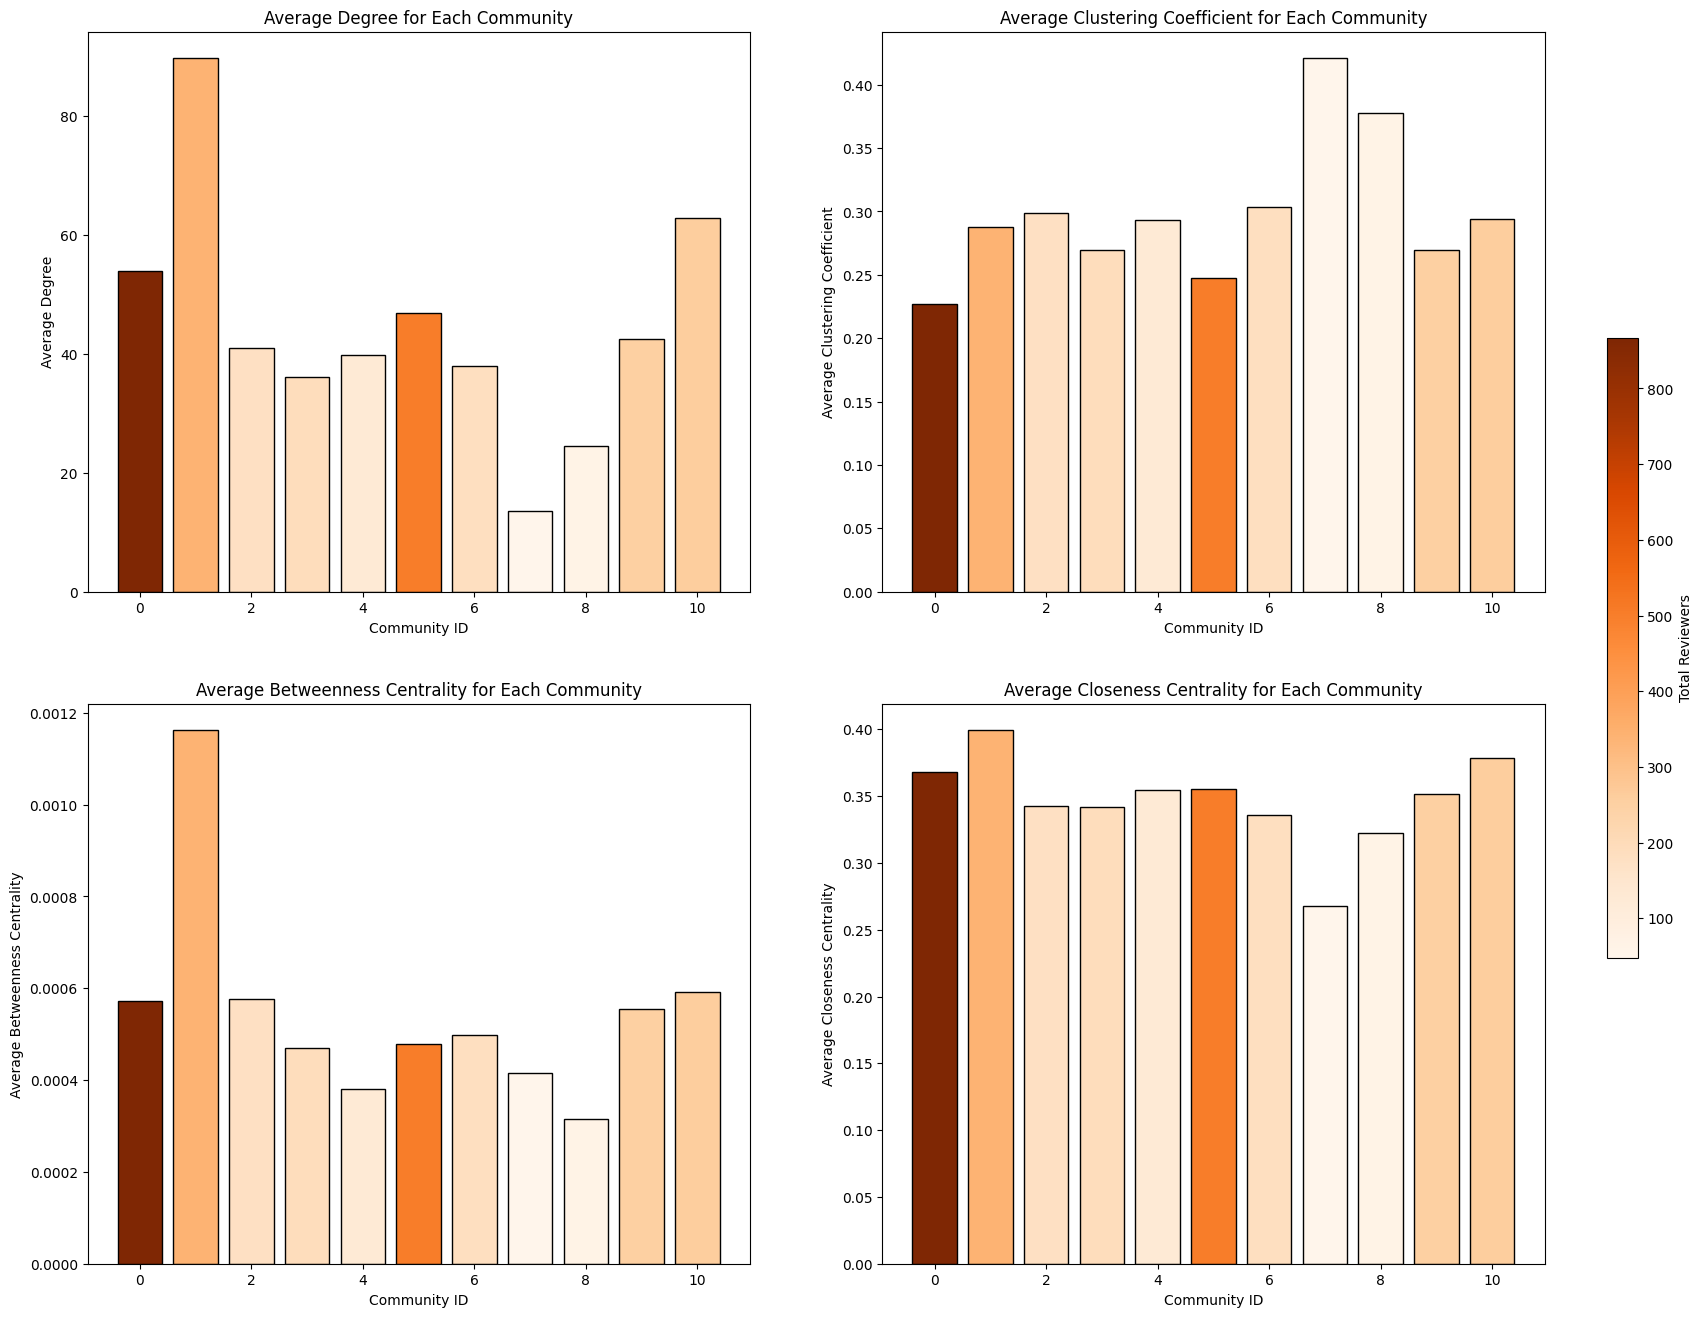

In [146]:
metrics = community_metrics_df.columns[1:-1]
plot_community_metrics(community_metrics_df, metrics, figsize=(20, 16))

Comments for the metric plots:  

Community 7’s low average degree combined with its high clustering coefficient indicates that, while it may have relatively few connections to the rest of the network or even internally, the nodes that are connected form a highly cohesive, tightly-knit structure. This could suggest specialized or fragmented behavior, hierarchical or niche relationships, or simply an isolated yet internally connected substructure within the broader network.  It is one of the smallest communities wich might make the results more uncertain.

Community 1's high centrality measures (betweenness, closeness) and high degree position it as a critical, well-connected hub within the network. However, the relatively low clustering coefficient suggests that, while the nodes are key to maintaining network connectivity and facilitating the spread of information or influence, they are not as strongly interconnected locally. This points to a community that plays a functional or structural role in the network rather than being a group of tightly-knit, socially cohesive nodes. Community 1 may serve as a central connector across the network, rather than a collaborative or close-knit group.





### Business and community relationships

In [147]:
with open('yelp_academic_dataset_business.json', 'r') as f:
    business_data = pd.DataFrame([json.loads(line) for line in f])

business_data = business_data[business_data['business_id'].isin(businesses)]
business_data.to_csv('businesses_reviewed.csv', index=False)

In [152]:
os.chdir('/Users/kristineandersen/Desktop/Sociale grafer/Project/')
# load business and review data
review_data = pd.read_json(f'yelp_dataset/reviews_20.json', lines=True)
business_data = pd.read_csv('businesses_reviewed.csv')


In [153]:
review_sentiments = pd.read_csv('review_sentiments.csv').drop(columns=['Unnamed: 0'])


### Community sentiments

In [154]:
review_data = review_data.merge(review_sentiments, on='review_id')
review_data['community'] = review_data['user_id'].map(partition)

In [155]:
community_sentiments = review_data.groupby('community')['sentiment'].mean().reset_index()
community_sentiments.columns = ['Community', 'Average Sentiment']
community_metrics_df = community_metrics_df.merge(community_sentiments, on='Community')

As seen earlier, the average sentiment score for each community was pretty much the same, thus, the distribution is plotted below

/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_17567/1055828165.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


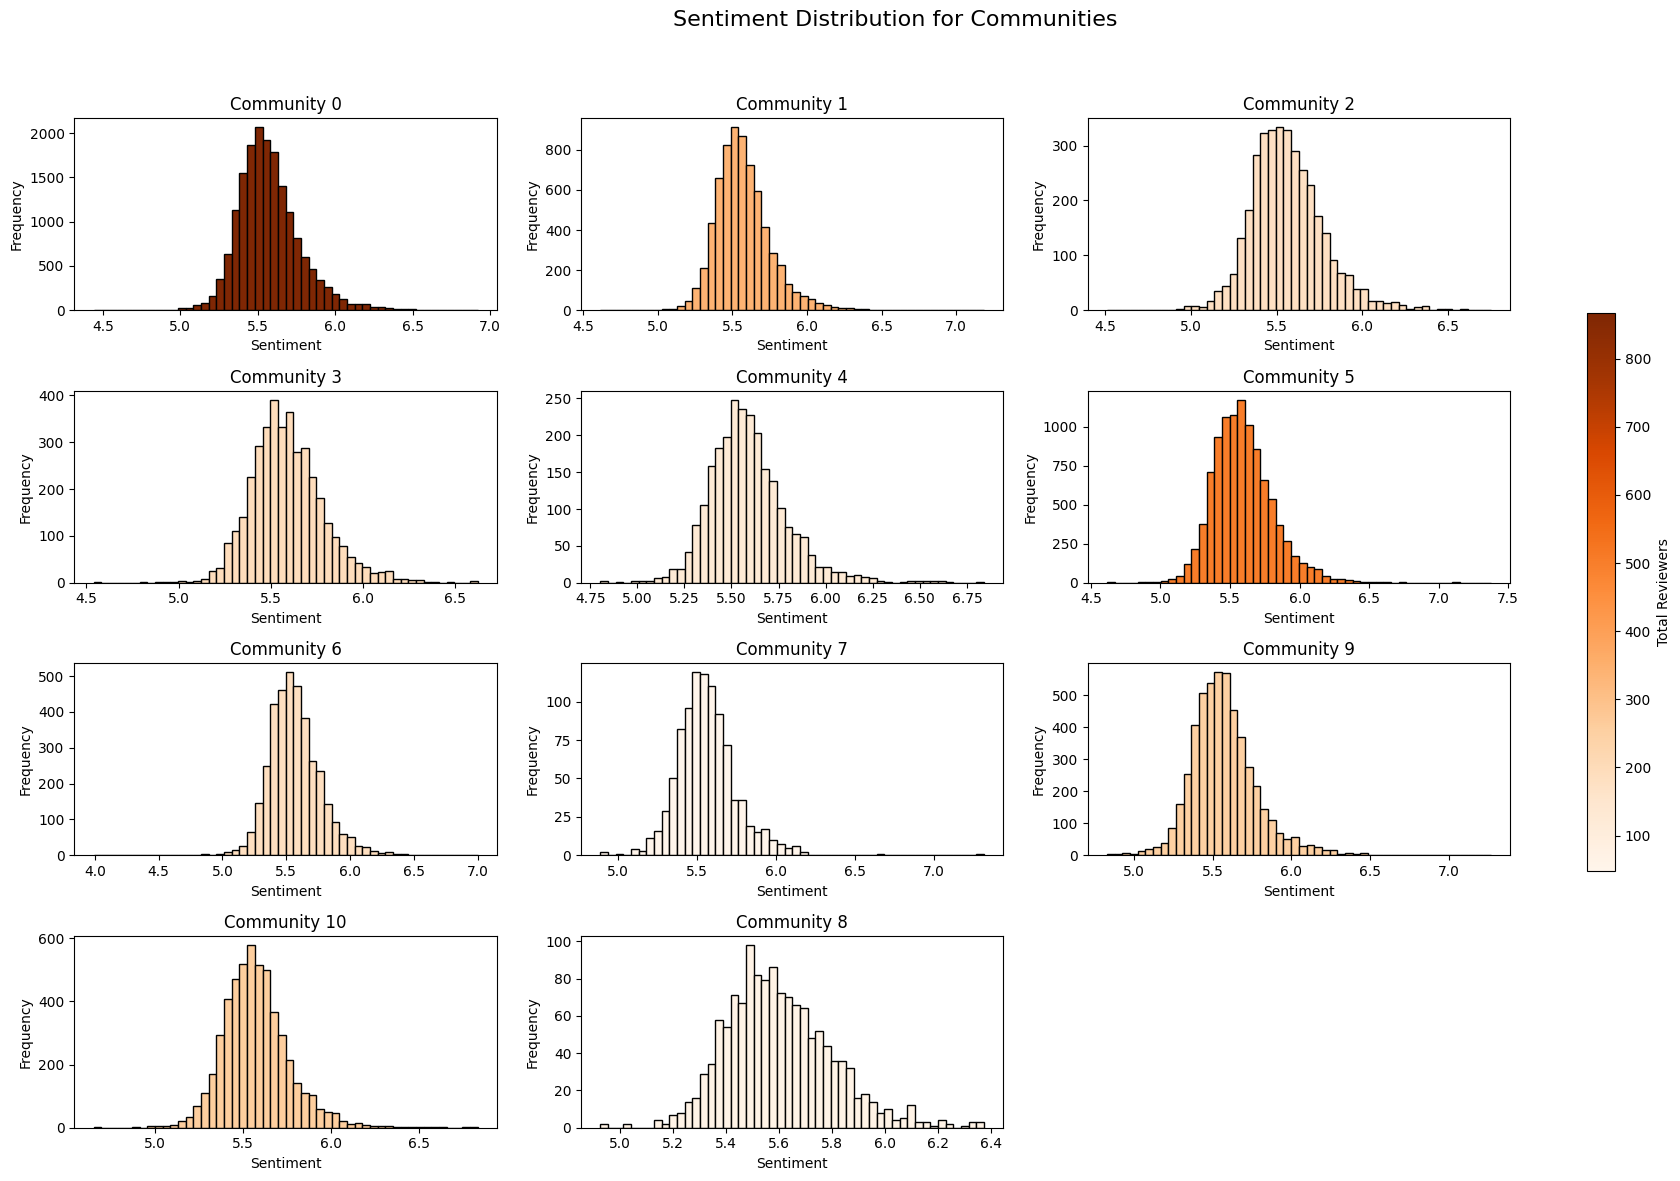

In [157]:
# sentiment for communities

num_communities = len(community_metrics_df)
num_cols = 3
num_rows = (num_communities + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten() 

norm = mcolors.Normalize(vmin=community_metrics_df["Total Reviewers"].min(), vmax=community_metrics_df["Total Reviewers"].max())
cmap = plt.get_cmap('Oranges')

for ax, community in zip(axes, community_metrics_df['Community']):
    community_sentiments = review_data[review_data['community'] == community]['sentiment']
    color = cmap(norm(community_metrics_df[community_metrics_df['Community'] == community]['Total Reviewers'].values[0]))
    ax.hist(community_sentiments, bins=50, color=color, edgecolor='black')
    ax.set_title(f'Community {community}')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for i in range(len(community_metrics_df), len(axes)):
    fig.delaxes(axes[i])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Total Reviewers')

plt.suptitle('Sentiment Distribution for Communities', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


As the plots show, very similar sentiment characteristics are within the different communities. The average sentiment are close to identical, and the distributions display equal structure.

### Examples of divergence in sentiment and star rating
examples that might be used to explain what future work can be done for sentiment analysis

In [158]:
# find high sentiment and low star reviews

low_star_threshold = 2
high_sentiment_threshold = 5.5
low_star_high_sentiment_reviews = review_data[(review_data['stars'] <= low_star_threshold) & (review_data['sentiment'] >= high_sentiment_threshold)]
for val in low_star_high_sentiment_reviews['text'].head():
    print(val)
    print()

Great location, food was horrible, service was good.

Jet-Plane Volume Music Kills Festivity or Romance in this Tired Bar in the Sky

51 stories in the air cannot save this confused, joyless place. Pay your $5 cover, which I suspect pays for the many bouncers, and walk into a place that will not work for you:
* Social occasion with friends? Nope! Unless you like screaming over your picnic table so people can hear you, forget happy chit-chat. 
* Romantic? Nope! Some ladies were really dressed up, and looked ridiculous sitting at the picnic tables. No privacy, no cozy corners. No candles.
* Happy, pleasant music? Nope! This is the same pounding, unhappy music you  hear on the street when an obnoxious car passes you and it is so loud it disturbs everybody on the sidewalk. It might be suitable to a rougher dance club, except nobody dancing here! Totally inappropriate music. 
* Great Design? Nope! Just some wooden picnic tables, some beer bottles over the light fixtures, and pictures of hap

In [ ]:
# average star rating for each community

community_star_ratings = review_data.groupby('community')['stars'].mean().reset_index()
community_star_ratings.columns = ['Community', 'Average Star Rating']
community_metrics_df = community_metrics_df.merge(community_star_ratings, on='Community')

In [160]:
community_metrics_df.head()

Community  Average Degree  Average Clustering Coefficient  \
0          0       53.965398                        0.226967   
1          1       89.645161                        0.287768   
2          2       40.921788                        0.298751   
3          3       36.077720                        0.269373   
4          4       39.728000                        0.293179   

   Average Betweenness Centrality  Average Closeness Centrality  \
0                        0.000572                      0.368264   
1                        0.001162                      0.399205   
2                        0.000577                      0.342736   
3                        0.000470                      0.341679   
4                        0.000380                      0.354437   

   Total Reviewers  Average Sentiment  Average Star Rating  
0              867           5.573728             3.726182  
1              341           5.571654             3.937537  
2              179           5.564336             3.668156  
3              193           5.590166             3.868394  
4              125           5.589415             3.897600

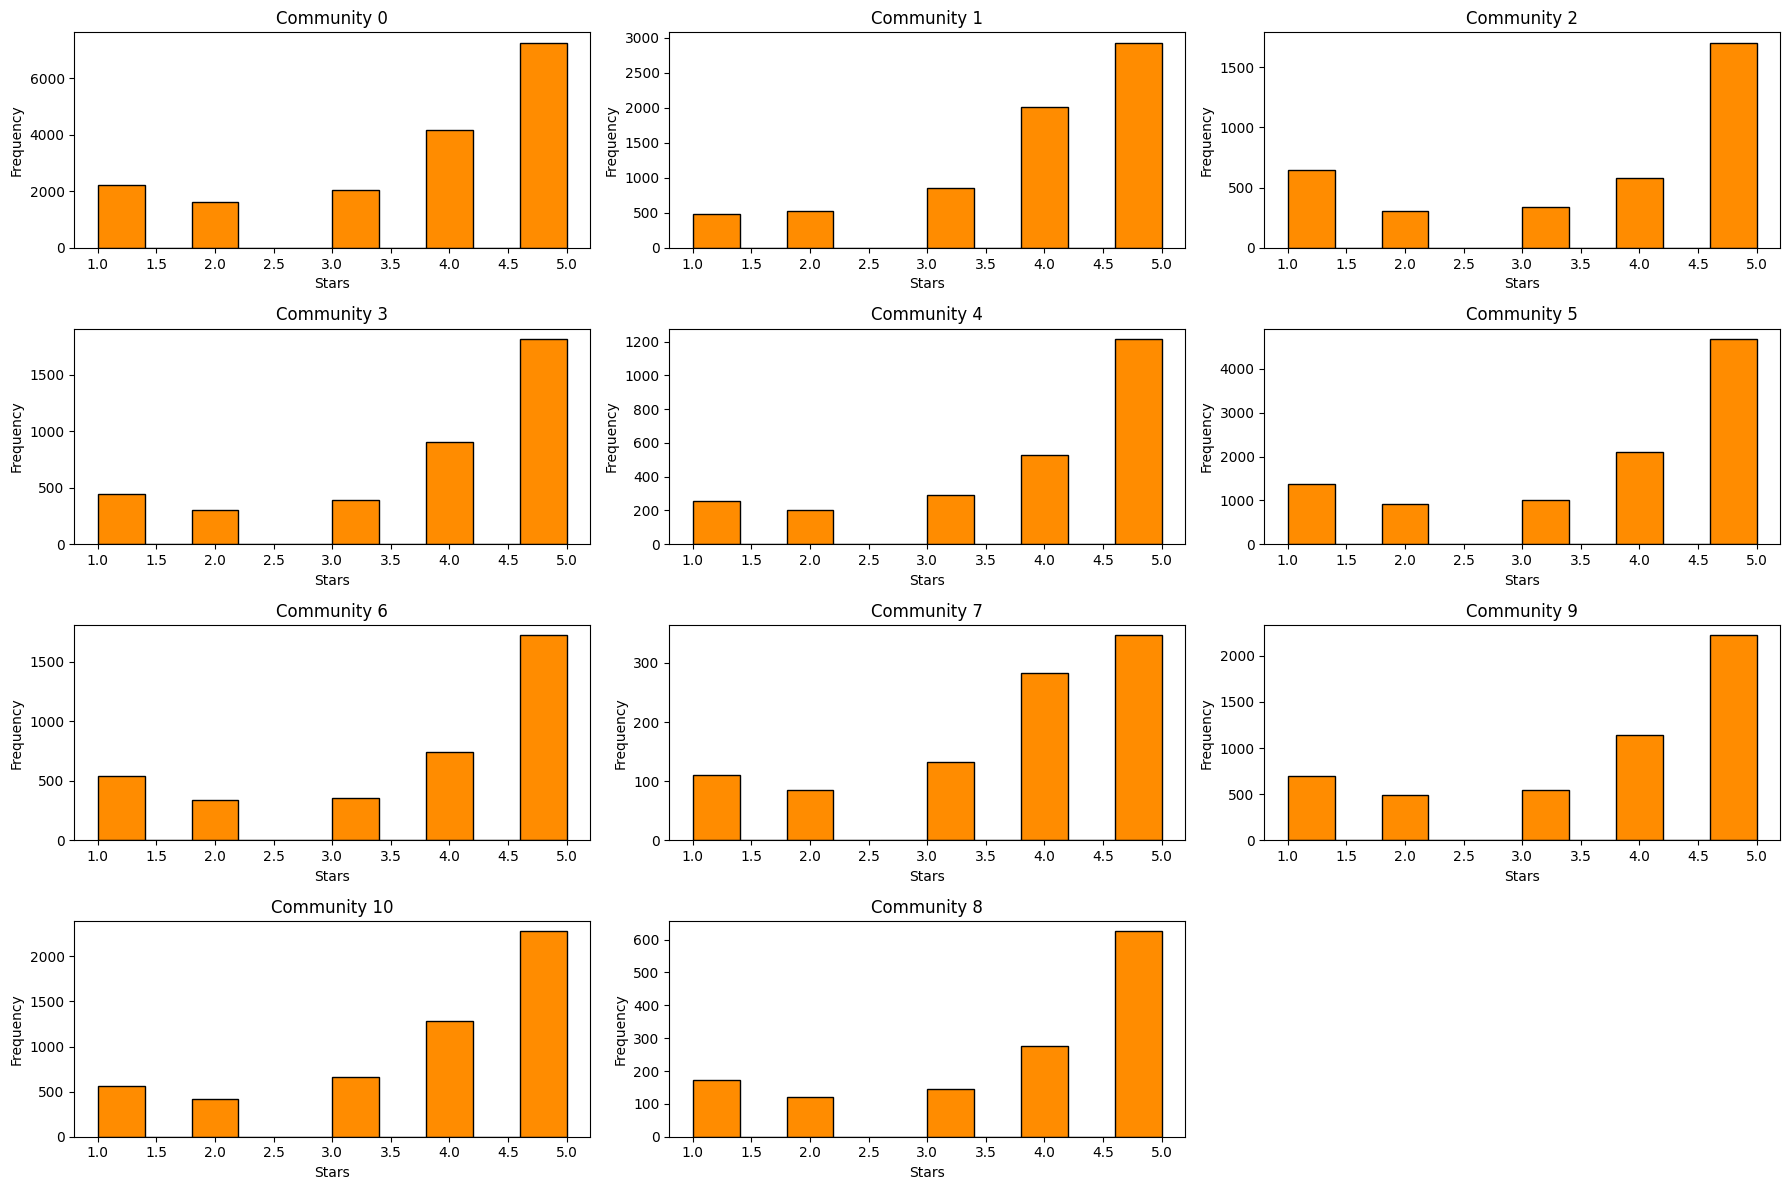

In [161]:
# Community star ratings
num_communities = len(community_metrics_df)
num_cols = 3
num_rows = (num_communities + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for ax, community in zip(axes, community_metrics_df['Community']):
    community_stars = review_data[review_data['community'] == community]['stars']
    ax.hist(community_stars, bins=10, color='darkorange', edgecolor='black')
    ax.set_title(f'Community {community}')
    ax.set_xlabel('Stars')
    ax.set_ylabel('Frequency')

for i in range(len(community_metrics_df), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Star ratings display similar distributions aswell as averages (as was seen earlier) across all communities. 

### Business geography

In [162]:
# average stars and communities for businesses

business_data['Avg. star rating'] = business_data['business_id'].map(review_data.groupby('business_id')['stars'].mean())
business_data['Community'] = business_data['business_id'].map(lambda x: review_data[review_data['business_id'] == x]['community'].mode()[0])


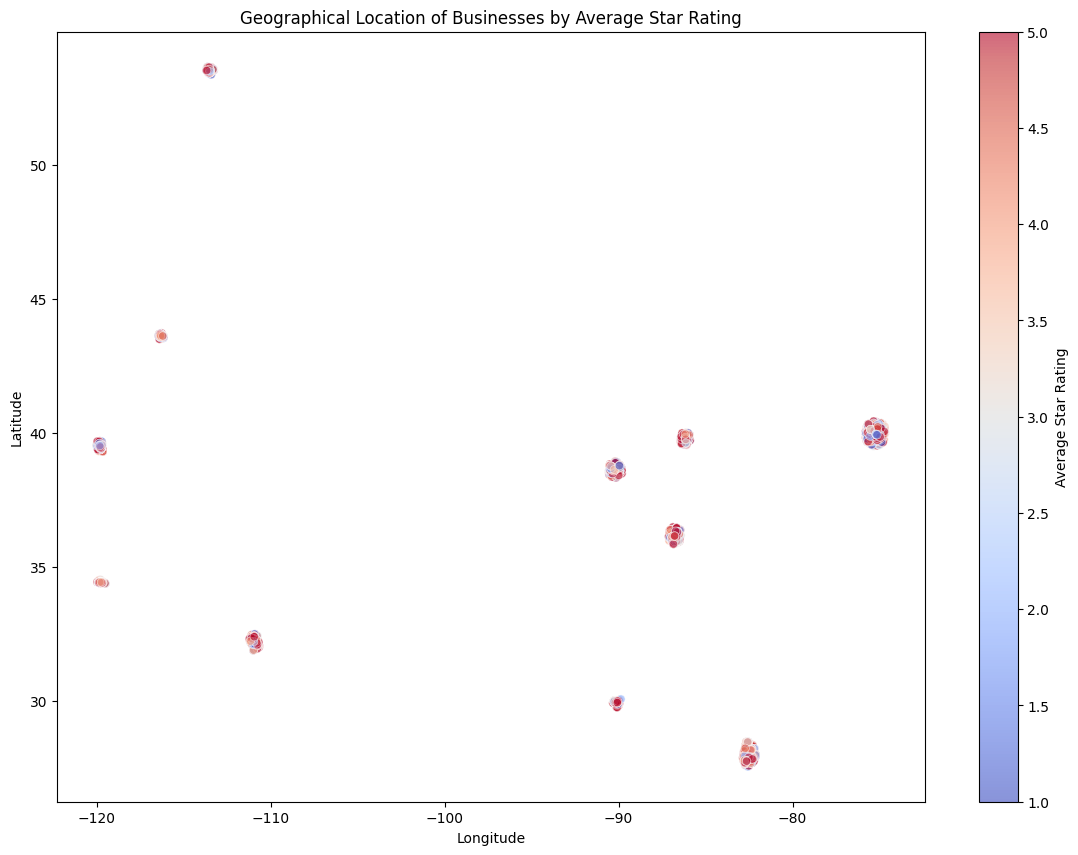

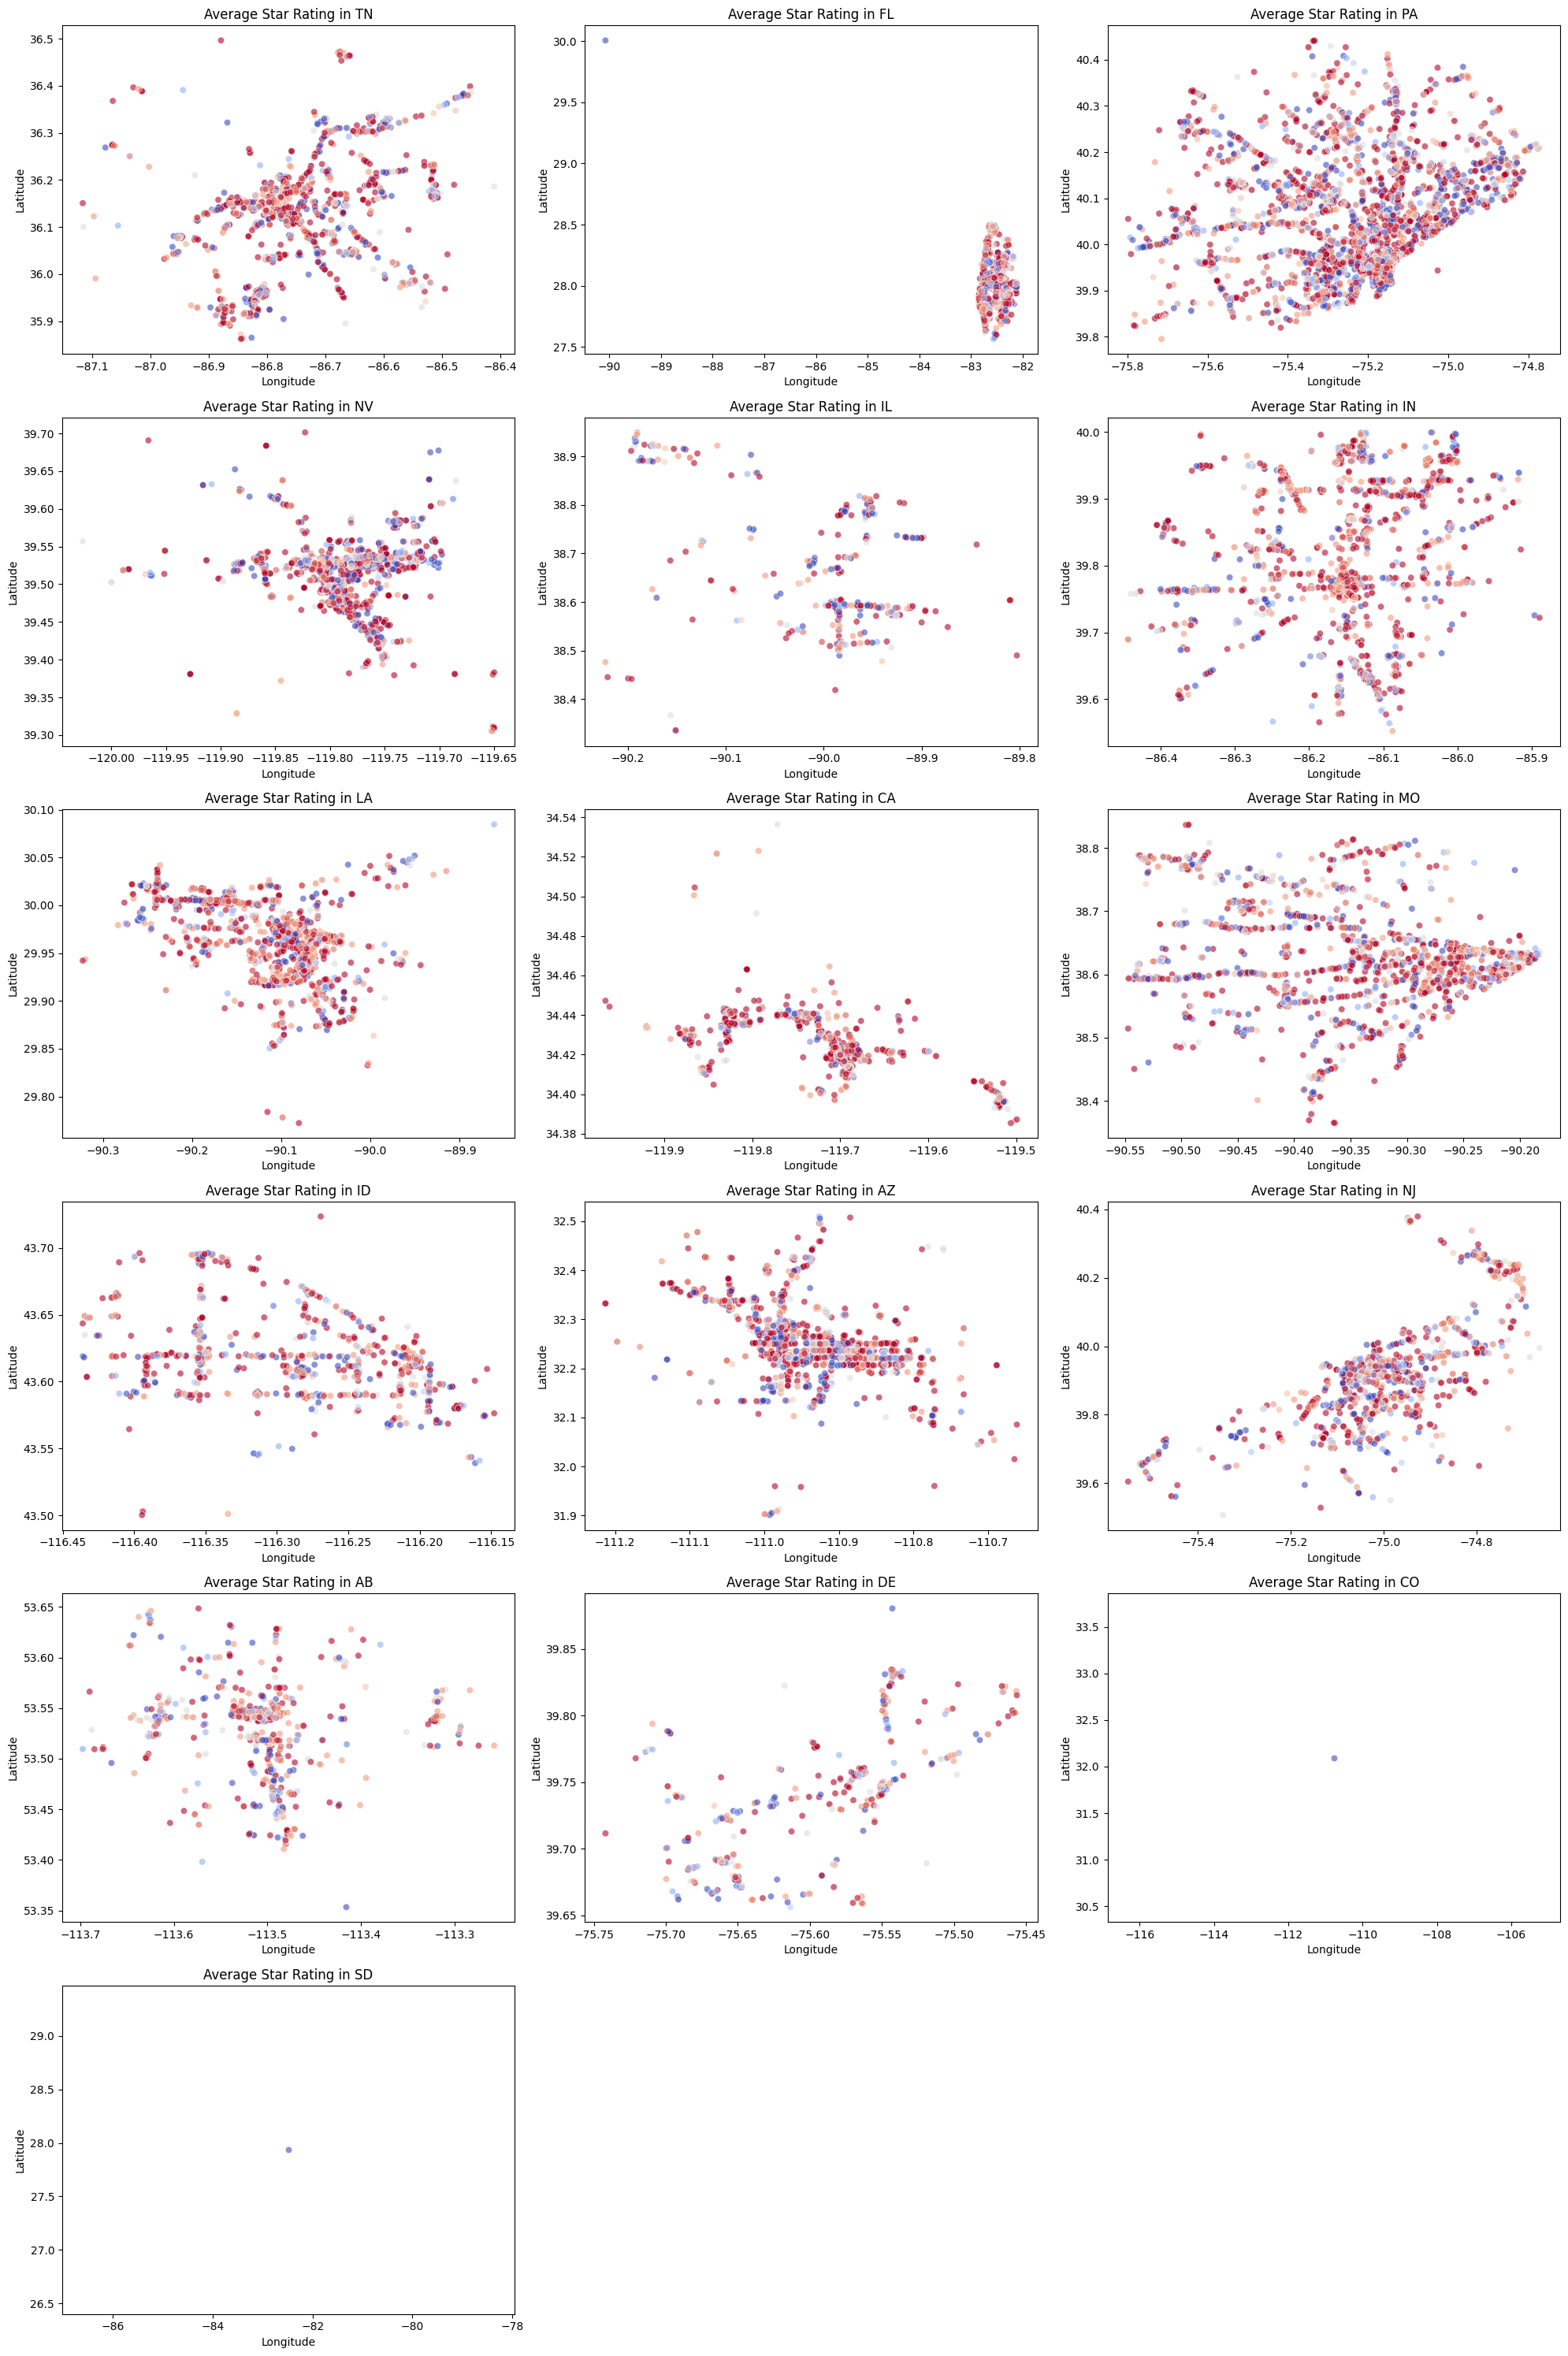

In [163]:
# Business locations with average star rating by reviewers

fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(business_data['longitude'], business_data['latitude'], 
                     c=business_data['Avg. star rating'], cmap='coolwarm', alpha=0.6, edgecolors='w', linewidth=0.5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average Star Rating')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographical Location of Businesses by Average Star Rating')

plt.show()

# Unique states in the business data

unique_states = business_data['state'].unique()
num_states = len(unique_states)
num_cols = 3
num_rows = (num_states + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for ax, state in zip(axes, unique_states):
    state_data = business_data[business_data['state'] == state]
    scatter = ax.scatter(state_data['longitude'], state_data['latitude'], 
                         c=state_data['Avg. star rating'], cmap='coolwarm', alpha=0.6, edgecolors='w', linewidth=0.5)
    ax.set_title(f'Average Star Rating in {state}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Hide any unused subplots
for i in range(len(unique_states), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


The above plots displays the average star ratings of business. It seems ratings are widely distributed and not clear patterns are visible for ratings based on geographical location.

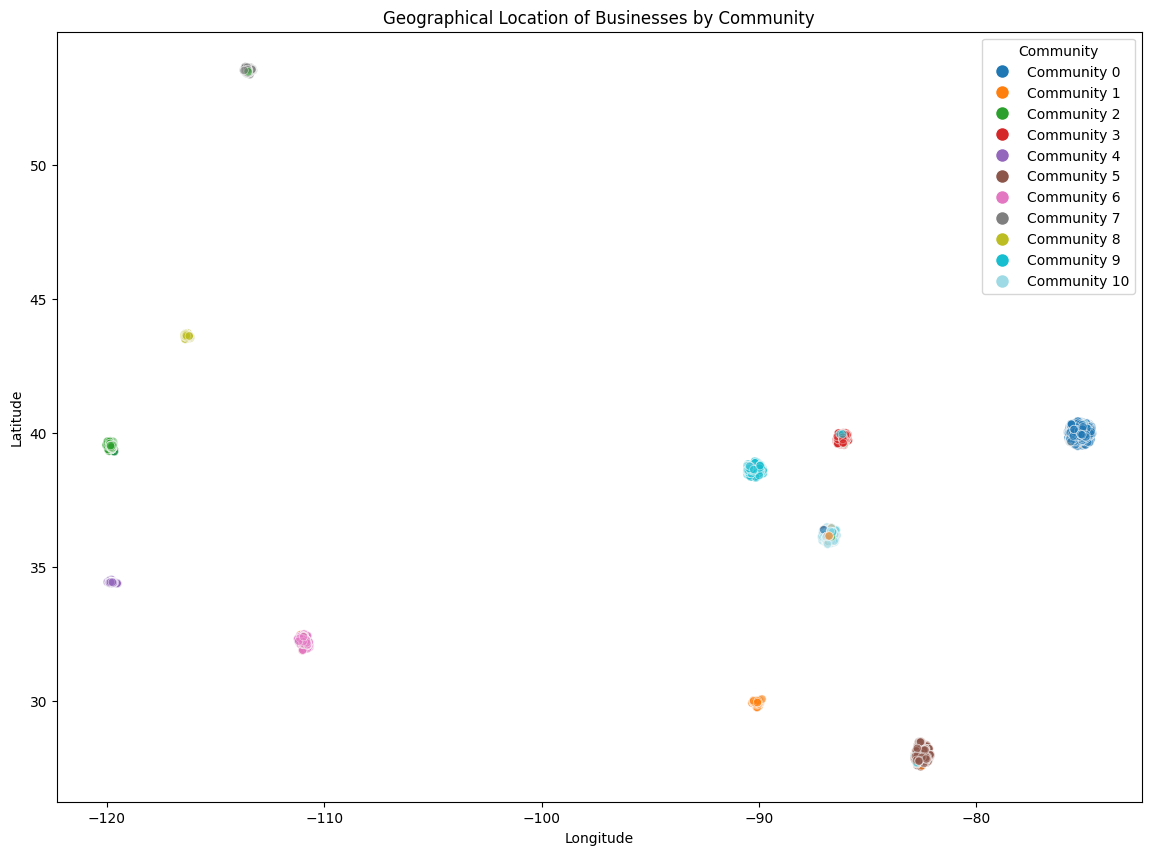

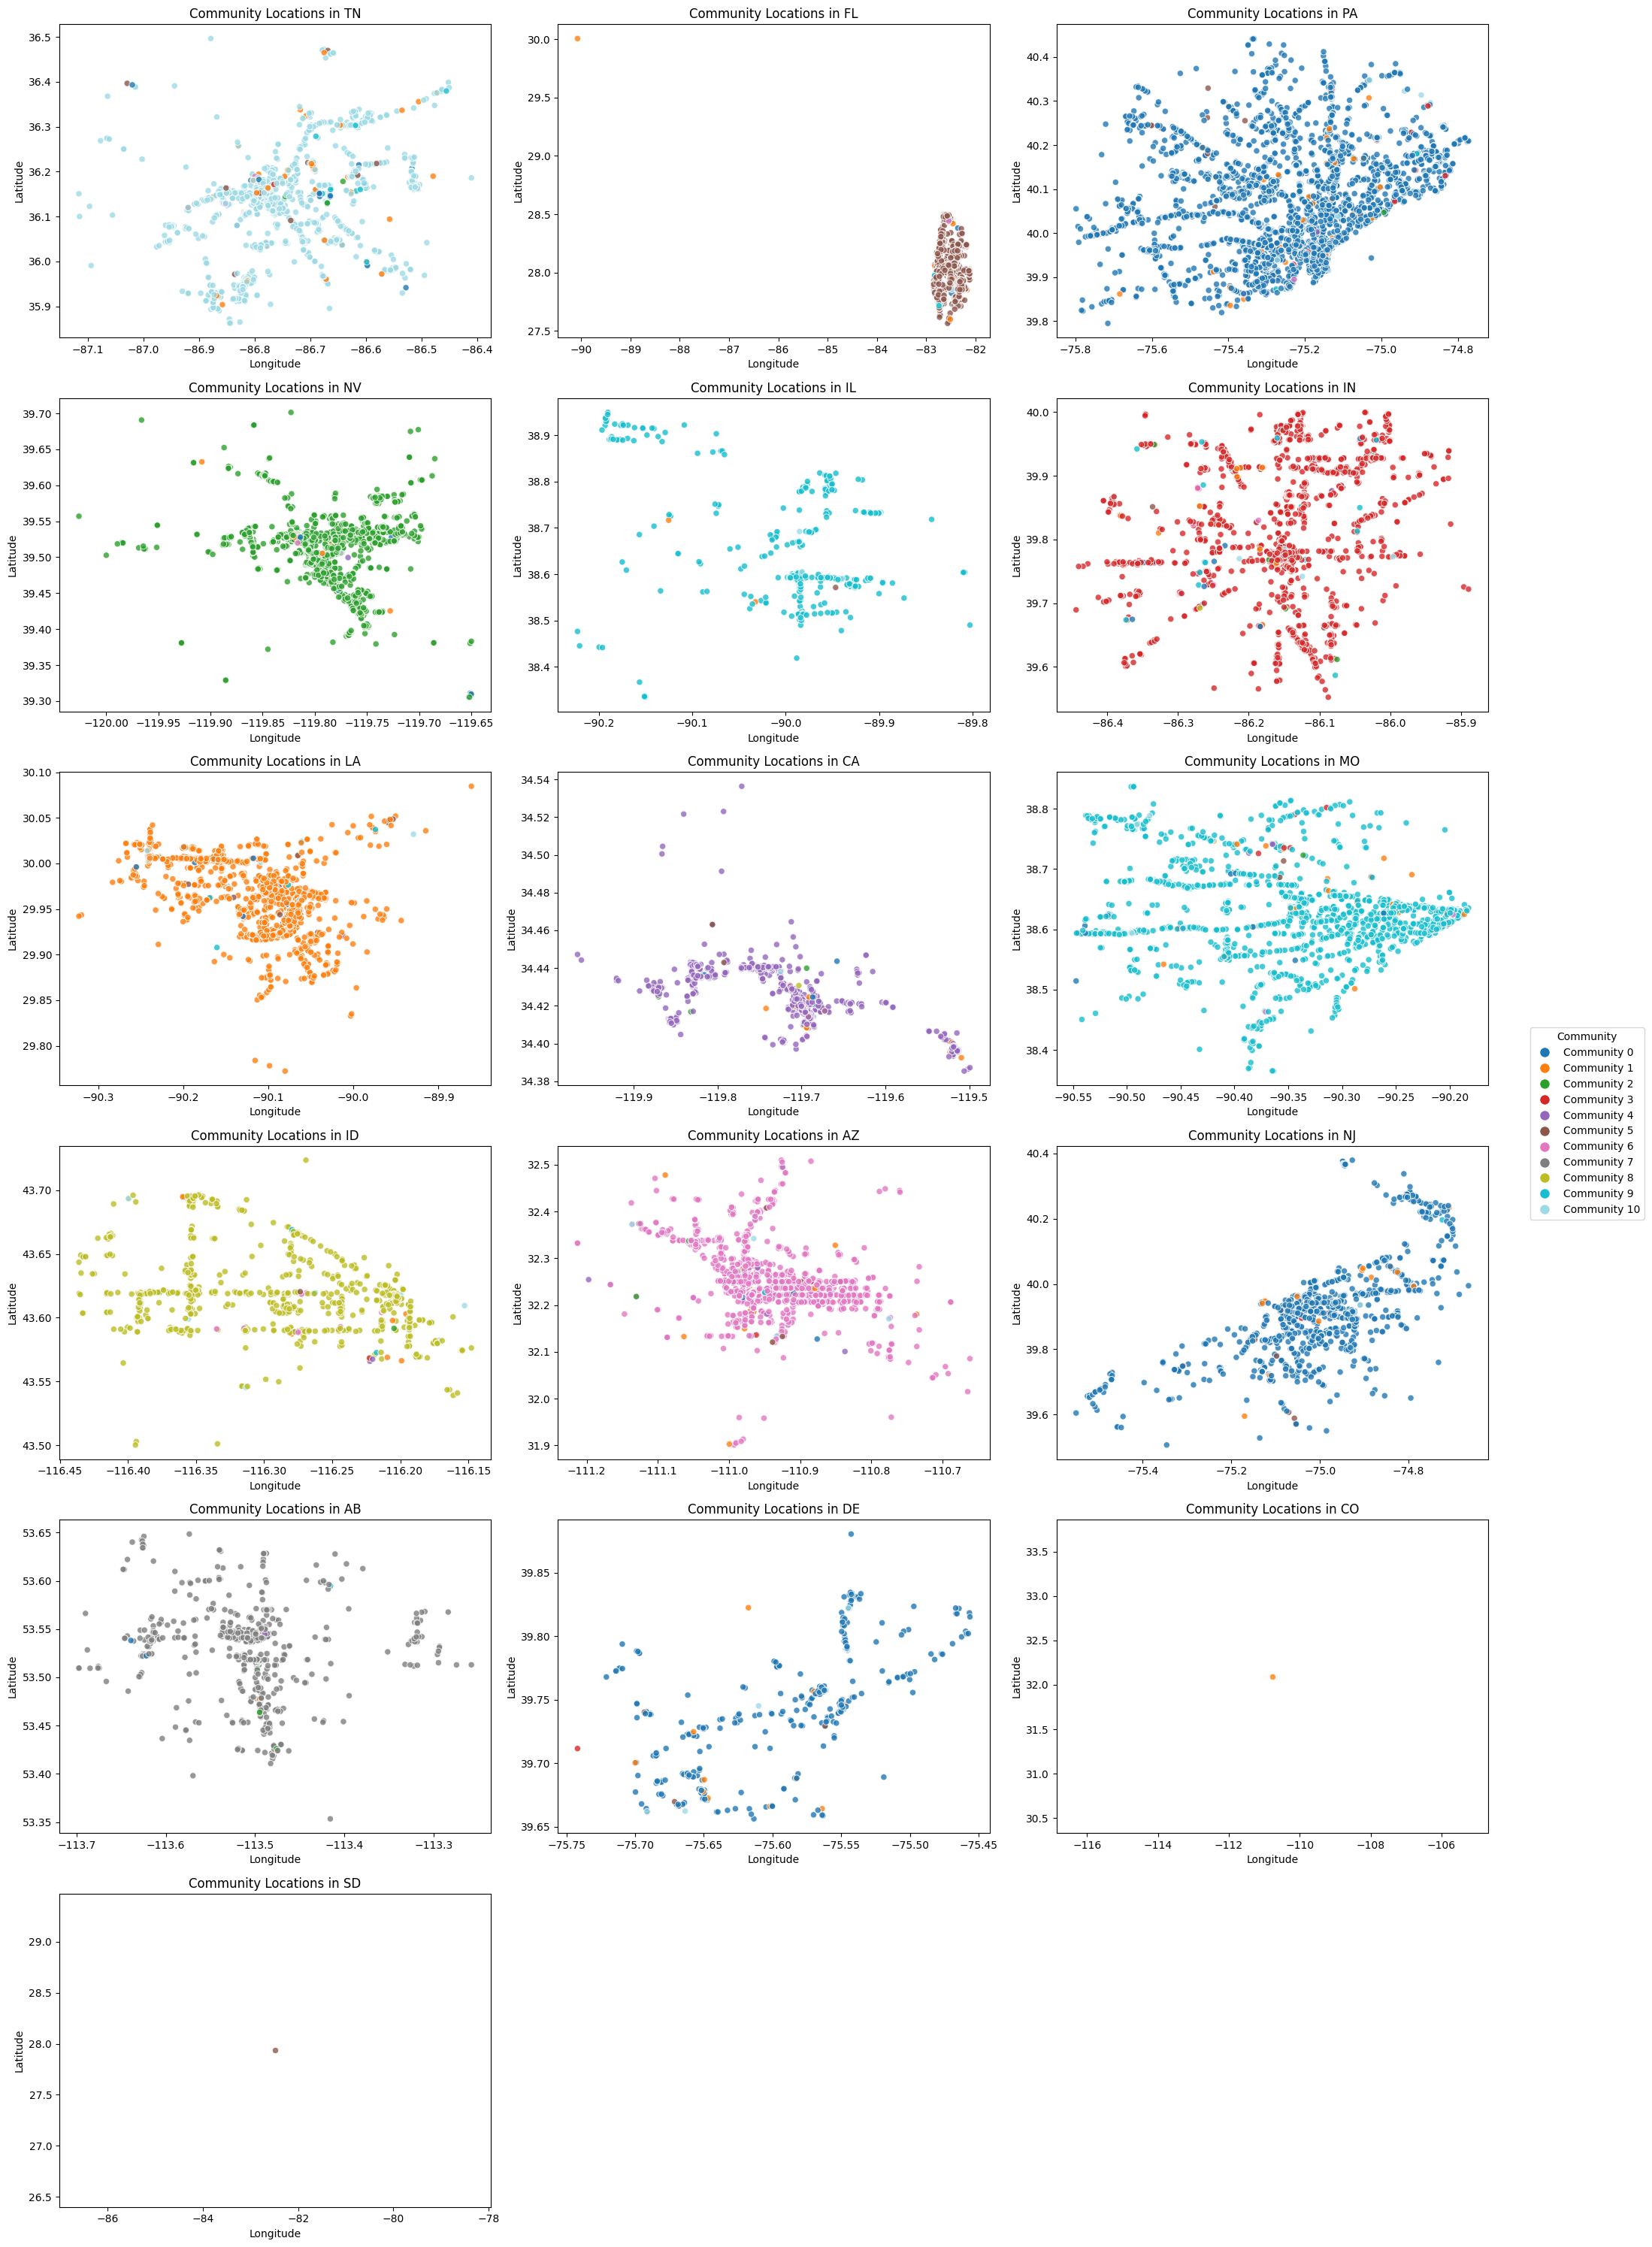

In [164]:
# business community locations
#  
unique_communities = sorted(business_data['Community'].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
community_color_map = {community: color for community, color in zip(unique_communities, colors)}

fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(business_data['longitude'], business_data['latitude'], 
                     color=business_data['Community'].map(community_color_map), alpha=0.6, edgecolors='w', linewidth=0.5)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {community}') 
           for community, color in community_color_map.items()]
ax.legend(handles=handles, title='Community', loc='upper right')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographical Location of Businesses by Community')
plt.show()

# unique states
unique_states = business_data['state'].unique()
num_states = len(unique_states)
num_cols = 3
num_rows = (num_states + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for ax, state in zip(axes, unique_states):
    state_data = business_data[business_data['state'] == state]
    scatter = ax.scatter(state_data['longitude'], state_data['latitude'], 
                         color=state_data['Community'].map(community_color_map), alpha=0.8, edgecolors='w', linewidth=0.7)
    ax.set_title(f'Community Locations in {state}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
for i in range(len(unique_states), len(axes)):
    fig.delaxes(axes[i])

fig.legend(handles=handles, title='Community', loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.show()


The plots illustrates how the communities aligns well with locations of reviewed businesses. While the sentiment and star rating measures are very similir across communities, geography highlights the clear seperation of the communities. This indicates that a primary factor for high modularity in the network communities, can be explained from the location of the reviewed businesses.
The specific metrics for the communities, supports the narrative seen from the plots above. 

Community 0, centered in Philadelphia, Pennsylvania, is the largest and most structurally balanced community in the network. It demonstrates a moderate average degree of 53.88 and a clustering coefficient of 0.227, indicative of stable but not overly dense connections among reviewers. The closeness centrality of 0.368 highlights efficient communication paths within the network. Businesses in this community cluster distinctly in Philadelphia, showcasing the influence of a well-defined local business ecosystem on reviewer interactions. The cohesion and size of this community reflect the integral role of geography in structuring social connections.  

Community 5, primarily situated in Florida's Tampa Bay area, is a geographically tight-knit and structurally cohesive community. It features a slightly lower average degree of 39.73 but compensates with a higher clustering coefficient of 0.293, revealing tightly-knit groups of reviewers engaging with businesses in this region. The closeness centrality of 0.354 underscores moderate connectivity within the network. Businesses in this community are geographically distinct, and their modularity highlights the impact of local networks on fostering dense reviewer interactions within a regional business hub.  

Community 9, localized in Nashville, Tennessee, represents a smaller yet cohesive network. With an average degree of 35.70 and a clustering coefficient of 0.27, this community reflects tightly-bound but less extensive connections. The closeness centrality of 0.341 suggests slightly reduced network efficiency compared to larger communities. Businesses within Nashville show clear geographic clustering, emphasizing how smaller urban centers can develop robust but localized reviewer ecosystems, driven by concentrated interactions among community members.

Tying the structural metrics of the communities to their geographic roots, demonstrates how local business environments might drive social network formation and connectivity within the Yelp reviewer network. 

### Highlighted communities

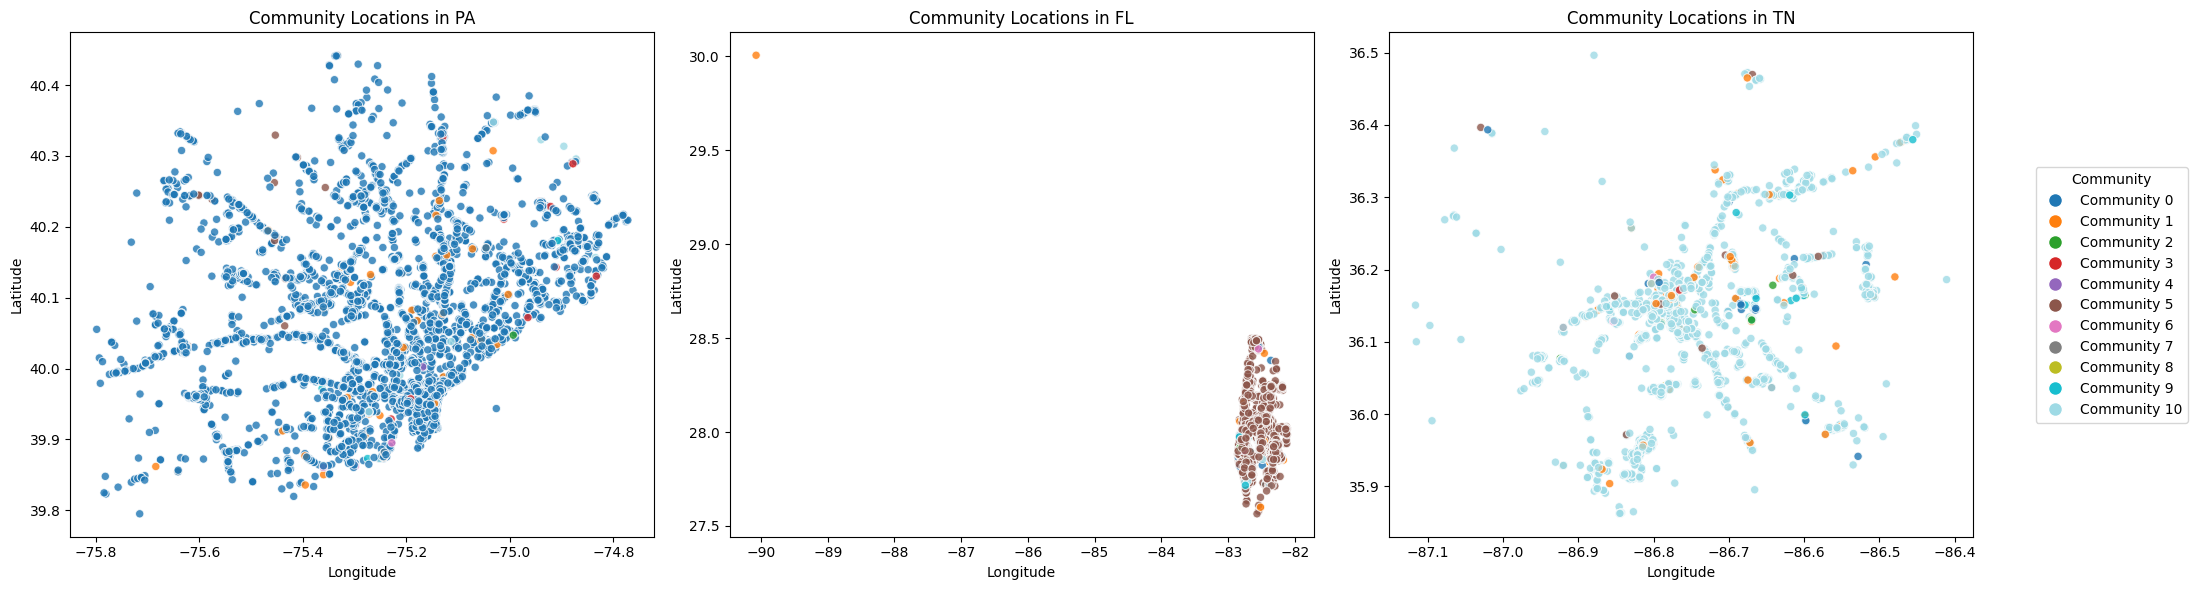

In [165]:
unique_communities = sorted(business_data['Community'].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
community_color_map = {community: color for community, color in zip(unique_communities, colors)}

# Filter for specific states
states_to_plot = ['PA', 'FL', 'TN']
state_data = business_data[business_data['state'].isin(states_to_plot)]

num_states = len(states_to_plot)
fig, axes = plt.subplots(1, num_states, figsize=(20, 6))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for ax, state in zip(axes, states_to_plot):
    state_data = business_data[business_data['state'] == state]
    scatter = ax.scatter(state_data['longitude'], state_data['latitude'], 
                         color=state_data['Community'].map(community_color_map), alpha=0.8, edgecolors='w', linewidth=0.7)
    ax.set_title(f'Community Locations in {state}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Community {community}') 
           for community, color in community_color_map.items()]

fig.legend(handles=handles, title='Community', loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.show()
